<a href="https://colab.research.google.com/github/tanghuakang/A-SMD-Based-Domain-Adaptive-Change-Detection-Method/blob/main/A%20SMD-Based%20Domain%20Adaptive%20CD%20Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

In [ ]:
!pip uninstall keras

Uninstalling Keras-2.4.3:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/Keras-2.4.3.dist-info/*
    /usr/local/lib/python3.6/dist-packages/docs/*
    /usr/local/lib/python3.6/dist-packages/keras/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.6/dist-packages/docs/md_autogen.py
    /usr/local/lib/python3.6/dist-packages/docs/update_docs.py
Proceed (y/n)? y
  Successfully uninstalled Keras-2.4.3


In [ ]:
!pip install keras==2.0.4

     |████████████████████████████████| 204kB 5.6MB/s 
  Created wheel for keras: filename=Keras-2.0.4-cp36-none-any.whl size=235519 sha256=398d9df87d37e94222724615633eec1306ae093d9e16c35d85ff9860ed9da130
  Stored in directory: /root/.cache/pip/wheels/92/11/19/2b4dda9f2301c140d1ac59460321c5be612c7cde4f26a8b8be
Successfully built keras
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.0.4 which is incompatible.


In [ ]:
# -*- coding: utf-8 -*-
"""Normalization layers.
This implements the AdaptiveBatchNormalization layer for Keras.
The class is a modified version of the BatchNormalization class in Keras github.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


#from keras.engine.base_layer import Layer, InputSpec
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints
from tensorflow.keras import backend as K
from keras.legacy import interfaces
# import keras.legacy.interfaces 
#!pip install keras==2.0.4


class AdaptiveBatchNormalization(Layer):
    """Batch normalization layer (Ioffe and Szegedy, 2014).
    Normalize the activations of the previous layer at each batch,
    i.e. applies a transformation that maintains the mean activation
    close to 0 and the activation standard deviation close to 1.
    # Arguments
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `BatchNormalization`.
        momentum: Momentum for the moving mean and the moving variance.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        moving_mean_initializer: Initializer for the moving mean.
        moving_variance_initializer: Initializer for the moving variance.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
    # Output shape
        Same shape as input.
    # References
        - [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)
    """

    @interfaces.legacy_batchnorm_support
    def __init__(self,
                 axis=-1,
                 momentum=0.99,
                 epsilon=1e-3,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 moving_mean_initializer='zeros',
                 moving_variance_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(AdaptiveBatchNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis
        self.momentum = momentum
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.moving_mean_initializer = initializers.get(moving_mean_initializer)
        self.moving_variance_initializer = initializers.get(moving_variance_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        dim = input_shape[self.axis]
        if dim is None:
            raise ValueError('Axis ' + str(self.axis) + ' of '
                             'input tensor should have a defined dimension '
                             'but the layer received an input with shape ' +
                             str(input_shape) + '.')
        self.input_spec = InputSpec(ndim=len(input_shape),
                                    axes={self.axis: dim})
        shape = (dim,)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.moving_mean = self.add_weight(
            shape=shape,
            name='moving_mean',
            initializer=self.moving_mean_initializer,
            trainable=False)
        self.moving_variance = self.add_weight(
            shape=shape,
            name='moving_variance',
            initializer=self.moving_variance_initializer,
            trainable=False)
        self.built = True

    def call(self, inputs, training=None):
        input_shape = K.int_shape(inputs)
        # Prepare broadcasting shape.
        ndim = len(input_shape)
        reduction_axes = list(range(len(input_shape)))
        del reduction_axes[self.axis]
        broadcast_shape = [1] * len(input_shape)
        broadcast_shape[self.axis] = input_shape[self.axis]

        # Determines whether broadcasting is needed.
        needs_broadcasting = (sorted(reduction_axes) != list(range(ndim))[:-1])

        def normalize_inference():
            normed_inference, mean, variance = K.normalize_batch_in_training(
                inputs, self.gamma, self.beta, reduction_axes,
                epsilon=self.epsilon
                )

            if needs_broadcasting:
                # In this case we must explicitly broadcast all parameters.
                broadcast_mean = K.reshape(mean,
                                                  broadcast_shape)
                broadcast_variance = K.reshape(variance,
                                                      broadcast_shape)
                if self.center:
                    broadcast_beta = K.reshape(self.beta, broadcast_shape)
                else:
                    broadcast_beta = None
                if self.scale:
                    broadcast_gamma = K.reshape(self.gamma,
                                                broadcast_shape)
                else:
                    broadcast_gamma = None
                return K.batch_normalization(
                    inputs,
                    broadcast_mean,
                    broadcast_variance,
                    broadcast_beta,
                    broadcast_gamma,
                    epsilon=self.epsilon)
            else:
                return K.batch_normalization(
                    inputs,
                    mean,
                    variance,
                    self.beta,
                    self.gamma,
                    epsilon=self.epsilon)

        # If the learning phase is *static* and set to inference:
        if training in {0, False}:
            return normalize_inference()

        # If the learning is either dynamic, or set to training:
        # In standard BN, mean and variance during training would be collected
        # and added to a moving average that's used at inference time.
        # In AdaBN we don't do this, as mean, var will be set on the testing data.
        normed_training, mean, variance = K.normalize_batch_in_training(
            inputs, self.gamma, self.beta, reduction_axes,
            epsilon=self.epsilon)

        if K.backend() != 'cntk':
            sample_size = K.prod([K.shape(inputs)[axis]
                                  for axis in reduction_axes])
            sample_size = K.cast(sample_size, dtype=K.dtype(inputs))

            # sample variance - unbiased estimator of population variance
            variance *= sample_size / (sample_size - (1.0 + self.epsilon))

        ##self.add_update([K.moving_average_update(self.moving_mean,
        ##                                         mean,
        ##                                         self.momentum),
        ##                 K.moving_average_update(self.moving_variance,
        ##                                         variance,
        ##                                         self.momentum)],
        ##                inputs)

        # Pick the normalized form corresponding to the training phase.
        return K.in_train_phase(normed_training, # in training
                                normalize_inference, # not in training
                                training=training)

    def get_config(self):
        config = {
            'axis': self.axis,
            'momentum': self.momentum,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'moving_mean_initializer': initializers.serialize(self.moving_mean_initializer),
            'moving_variance_initializer': initializers.serialize(self.moving_variance_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(BatchNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape


In [ ]:
import tensorflow as tf
# tf.enable_eager_execution()
tf.config.list_physical_devices('GPU')
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import pathlib

In [ ]:
data_dir = "/content/drive/MyDrive/RS_images_2800/RS_images_2800"

In [ ]:
data_root = pathlib.Path(data_dir)

In [ ]:
data_root

PosixPath('/content/drive/MyDrive/RS_images_2800/RS_images_2800')

In [ ]:
for item in data_root.iterdir():
  print(item)

/content/drive/MyDrive/RS_images_2800/RS_images_2800/gParking
/content/drive/MyDrive/RS_images_2800/RS_images_2800/dRiverLake
/content/drive/MyDrive/RS_images_2800/RS_images_2800/fResident
/content/drive/MyDrive/RS_images_2800/RS_images_2800/bField
/content/drive/MyDrive/RS_images_2800/RS_images_2800/eForest
/content/drive/MyDrive/RS_images_2800/RS_images_2800/aGrass
/content/drive/MyDrive/RS_images_2800/RS_images_2800/cIndustry


In [ ]:
all_image_path = list(data_root.glob('*/*'))

In [ ]:
image_count = len(all_image_path)

In [ ]:
all_image_path[-3:]

[PosixPath('/content/drive/MyDrive/RS_images_2800/RS_images_2800/cIndustry/c277.jpg'),
 PosixPath('/content/drive/MyDrive/RS_images_2800/RS_images_2800/cIndustry/c309.jpg'),
 PosixPath('/content/drive/MyDrive/RS_images_2800/RS_images_2800/cIndustry/c362.jpg')]

In [ ]:
import random
all_image_paths = [str(path) for path in all_image_path]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

2810

In [ ]:
all_image_paths[:10]

In [ ]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())

In [ ]:
label_names

['aGrass',
 'bField',
 'cIndustry',
 'dRiverLake',
 'eForest',
 'fResident',
 'gParking']

In [ ]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))

In [ ]:
label_to_index

{'aGrass': 0,
 'bField': 1,
 'cIndustry': 2,
 'dRiverLake': 3,
 'eForest': 4,
 'fResident': 5,
 'gParking': 6}

In [ ]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]

In [ ]:
all_image_labels[:10]

[6, 5, 4, 0, 3, 1, 5, 3, 2, 4]

In [ ]:
all_image_paths[:10]

['/content/drive/MyDrive/RS_images_2800/RS_images_2800/gParking/g060.jpg',
 '/content/drive/MyDrive/RS_images_2800/RS_images_2800/fResident/f020.jpg',
 '/content/drive/MyDrive/RS_images_2800/RS_images_2800/eForest/e167.jpg',
 '/content/drive/MyDrive/RS_images_2800/RS_images_2800/aGrass/a088.jpg',
 '/content/drive/MyDrive/RS_images_2800/RS_images_2800/dRiverLake/d017.jpg',
 '/content/drive/MyDrive/RS_images_2800/RS_images_2800/bField/b399.jpg',
 '/content/drive/MyDrive/RS_images_2800/RS_images_2800/fResident/f073.jpg',
 '/content/drive/MyDrive/RS_images_2800/RS_images_2800/dRiverLake/d181.jpg',
 '/content/drive/MyDrive/RS_images_2800/RS_images_2800/cIndustry/c365.jpg',
 '/content/drive/MyDrive/RS_images_2800/RS_images_2800/eForest/e045.jpg']

In [ ]:
import IPython.display as display

In [ ]:
def caption_image(label):
  return {0: 'aGrass',
 1: 'bField',
 2: 'cIndustry',
 3: 'dRiverLake',
 4: 'eForest',
 5: 'fResident',
 6: 'gParking'}.get(label)

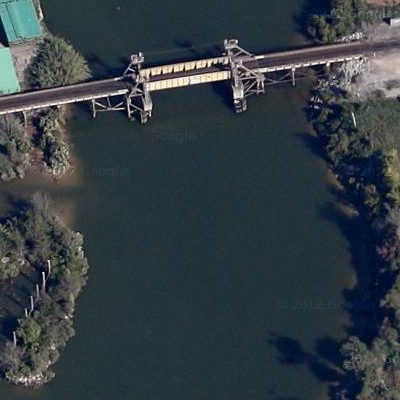

dRiverLake



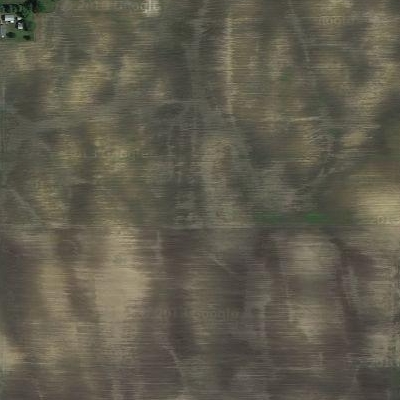

bField



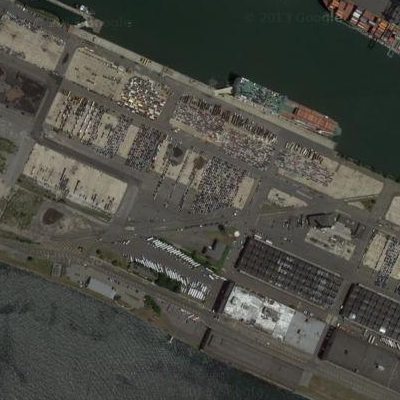

gParking



In [ ]:
for n in range(3):
  image_index = random.choice(range(len(all_image_paths)))
  display.display(display.Image(all_image_paths[image_index]))
  print(caption_image(all_image_labels[image_index]))
  print()

In [ ]:
img_path = all_image_paths[0]
img_path

'/content/drive/MyDrive/RS_images_2800/RS_images_2800/gParking/g060.jpg'

In [ ]:
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...") #读取到的图像是二进制编码

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00...


In [ ]:
img_tensor = tf.image.decode_image(img_raw)

In [ ]:
print(img_tensor.shape)
print(img_tensor.dtype)

(400, 400, 3)
<dtype: 'uint8'>


In [ ]:
img_tensor = tf.cast(img_tensor, tf.float32)
img_final = img_tensor/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(400, 400, 3)
0.0
1.0


In [ ]:
def load_preprocess_image(path):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [400,400])
  image = tf.cast(image, tf.float32)
  image = image/255.0
  return image

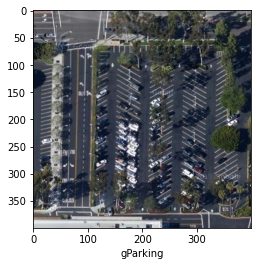

In [ ]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_preprocess_image(image_path))
plt.grid(False)
plt.xlabel(caption_image(label))
print()

In [ ]:
cmfas = "/content/drive/MyDrive/WHU_seg_ftclass_png/sub_images//2222.png"
imghh = plt.imread(cmfas)
imghh.shape

(256, 256, 4)

In [ ]:
read_img(cmfas)

# **UNet--->分割**

In [ ]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
tf.config.list_physical_devices('GPU')
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import pathlib
import re

In [ ]:
#img_png
img_root = glob.glob("/content/drive/MyDrive/WHU_seg_fourMulfour/subimage/*.png")
label_root = glob.glob("/content/drive/MyDrive/WHU_seg_fourMulfour/sublabel/*.png")

In [ ]:
len(img_root)

3077

In [ ]:
len(label_root)

3060

In [ ]:
img_root = sorted(img_root,key = lambda i:int(re.search(r'(\d+)',i).group()))
for i in range(len(img_root)-1):
  if int(re.search(r'(\d+)',img_root[i]).group())+1 != int(re.search(r'(\d+)',img_root[i+1]).group()):
    print(i)

27
266
272
704
706
708
710
712
714
716
718
720
2657
2659
2661
2663
2665


In [ ]:
img_root.remove('/content/drive/MyDrive/WHU_seg_fourMulfour/subimage/27 (1).png')
img_root.remove('/content/drive/MyDrive/WHU_seg_fourMulfour/subimage/265 (1).png')
img_root.remove('/content/drive/MyDrive/WHU_seg_fourMulfour/subimage/270 (1).png')
img_root.remove('/content/drive/MyDrive/WHU_seg_fourMulfour/subimage/701 (1).png')
img_root.remove('/content/drive/MyDrive/WHU_seg_fourMulfour/subimage/702 (1).png')
img_root.remove('/content/drive/MyDrive/WHU_seg_fourMulfour/subimage/703 (1).png')
img_root.remove('/content/drive/MyDrive/WHU_seg_fourMulfour/subimage/704 (1).png')
img_root.remove('/content/drive/MyDrive/WHU_seg_fourMulfour/subimage/705 (1).png')
img_root.remove('/content/drive/MyDrive/WHU_seg_fourMulfour/subimage/706 (1).png')
img_root.remove('/content/drive/MyDrive/WHU_seg_fourMulfour/subimage/707 (1).png')
img_root.remove('/content/drive/MyDrive/WHU_seg_fourMulfour/subimage/708 (1).png')
img_root.remove('/content/drive/MyDrive/WHU_seg_fourMulfour/subimage/709 (1).png')
img_root.remove('/content/drive/MyDrive/WHU_seg_fourMulfour/subimage/2645 (1).png')
img_root.remove('/content/drive/MyDrive/WHU_seg_fourMulfour/subimage/2646 (1).png')
img_root.remove('/content/drive/MyDrive/WHU_seg_fourMulfour/subimage/2647 (1).png')
img_root.remove('/content/drive/MyDrive/WHU_seg_fourMulfour/subimage/2648 (1).png')
img_root.remove('/content/drive/MyDrive/WHU_seg_fourMulfour/subimage/2649 (1).png')

In [ ]:
img = img_root
len(img)

3060

In [ ]:
img = sorted(img_root,key = lambda i:int(re.search(r'(\d+)',i).group()))

In [ ]:
img[-10:]

['/content/drive/MyDrive/WHU_seg_fourMulfour/subimage/3050.png',
 '/content/drive/MyDrive/WHU_seg_fourMulfour/subimage/3051.png',
 '/content/drive/MyDrive/WHU_seg_fourMulfour/subimage/3052.png',
 '/content/drive/MyDrive/WHU_seg_fourMulfour/subimage/3053.png',
 '/content/drive/MyDrive/WHU_seg_fourMulfour/subimage/3054.png',
 '/content/drive/MyDrive/WHU_seg_fourMulfour/subimage/3055.png',
 '/content/drive/MyDrive/WHU_seg_fourMulfour/subimage/3056.png',
 '/content/drive/MyDrive/WHU_seg_fourMulfour/subimage/3057.png',
 '/content/drive/MyDrive/WHU_seg_fourMulfour/subimage/3058.png',
 '/content/drive/MyDrive/WHU_seg_fourMulfour/subimage/3059.png']

In [ ]:
import re
label = sorted(label_root,key = lambda i:int(re.search(r'(\d+)',i).group()))

In [ ]:
label[:10]

['/content/drive/MyDrive/WHU_seg_fourMulfour/sublabel/0.png',
 '/content/drive/MyDrive/WHU_seg_fourMulfour/sublabel/1.png',
 '/content/drive/MyDrive/WHU_seg_fourMulfour/sublabel/2.png',
 '/content/drive/MyDrive/WHU_seg_fourMulfour/sublabel/3.png',
 '/content/drive/MyDrive/WHU_seg_fourMulfour/sublabel/4.png',
 '/content/drive/MyDrive/WHU_seg_fourMulfour/sublabel/5.png',
 '/content/drive/MyDrive/WHU_seg_fourMulfour/sublabel/6.png',
 '/content/drive/MyDrive/WHU_seg_fourMulfour/sublabel/7.png',
 '/content/drive/MyDrive/WHU_seg_fourMulfour/sublabel/8.png',
 '/content/drive/MyDrive/WHU_seg_fourMulfour/sublabel/9.png']

In [ ]:
len(label)

3060

In [ ]:
label_1 = label
img_1 = img

In [ ]:
len(img_1)

3060

In [ ]:
img_val=[]
for i in range(len(img_1)):
  if i%500==0:
    for item in img_1[i:i+20]:
      img_val.append(item)
      img_1.remove(item)

In [ ]:
len(img_1)

7000

In [ ]:
len(img_val)

280

In [ ]:
img_train = img_1
img_val = img_val

In [ ]:
label_val=[]
for i in range(len(label_1)):
  if i%500==0:
    for item in label_1[i:i+20]:
      label_val.append(item)
      label_1.remove(item)
#每个if已经删除了10个，注意

In [ ]:
len(label_1)

7000

In [ ]:
len(label_val)

280

In [ ]:
label_train = label_1
label_val = label_val

In [ ]:
#为了清楚明了
train_img = img_train
train_label = label_train
val_img = img_val
val_label = label_val

In [ ]:
len(train_img)

7000

In [ ]:
len(train_label)

7000

In [ ]:
len(val_img)

280

In [ ]:
len(val_label)

280

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_1, label_1))

In [ ]:
dataset_val = tf.data.Dataset.from_tensor_slices((val_img, val_label))

In [ ]:
img_unique = read_img("/content/drive/MyDrive/WHU_seg_fourMulfour/sublabel/3059.png")

In [ ]:
img_unique1 = read_img("/content/drive/MyDrive/WHU_seg_fourMulfour/subimage/1.png")

In [ ]:
# img_unique.numpy()
np.unique(img_unique)

array([ 0,  3, 15], dtype=uint8)

#数据增强

#图像加载函数

In [ ]:
import os,sys
import cv2
import numpy
from skimage import io   #使用IO库读取tif图片
# import tifffile as tiff

def read_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_png(img, channels=3)
  return img

def read_label(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_png(img, channels=1)
  return img

def normal(img, mask):
  # img = tf.cast(img, tf.float32)/127.5-1
  img = tf.cast(img, tf.float32)/255.0
  mask = tf.cast(mask, tf.int32)
  # mask = tf.cast(mask, tf.int32) 

  return img, mask


In [ ]:
import tensorflow as tf
img = tf.io.read_file("/content/drive/MyDrive/WHU_seg_fourMulfour/subimage/1.png")
img = tf.image.decode_png(img, channels = 3)

In [ ]:
type(img)

tensorflow.python.framework.ops.EagerTensor

In [ ]:
def load_img_train(img_path, mask_path):
  img = read_img(img_path)
  mask = read_label(mask_path)

  img, mask = normal(img, mask)

  if tf.random.uniform(()) > 0.5:
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)

  return img, mask

def load_img_val(img_path, mask_path):
  img = read_img(img_path)
  mask = read_label(mask_path)

  img, mask = normal(img, mask)

  return img, mask



In [ ]:
BATCH_SIZE = 10
BUFFER_SIZE = 300

step_per_epoch = 3060 // BATCH_SIZE
# val_per = 280 // BATCH_SIZE

In [ ]:
auto = tf.data.experimental.AUTOTUNE

In [ ]:
dataset_train = dataset.map(load_img_train, num_parallel_calls=auto)
# dataset_val = dataset_val.map(load_img_val, num_parallel_calls=auto)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


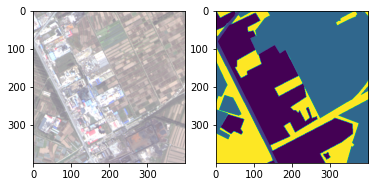

In [ ]:
for i,m in dataset_train.take(2):
  plt.subplot(1,2,1)
  a = i.shape
  plt.imshow((i.numpy()+1)/2)
  plt.subplot(1,2,2)
  b = m.shape
  plt.imshow(np.squeeze(m.numpy()))

In [ ]:
b #TensorShape([256, 256, 3])
# TensorShape([256, 256, 3])   ---- >  b

TensorShape([256, 256, 1])

In [ ]:
dataset_train_0.take(1)

In [ ]:
dataset_train_0 = dataset_train.cache().repeat().shuffle(300).batch(BATCH_SIZE).prefetch(auto)

# dataset_val_0 = dataset_val.cache().batch(1)

In [ ]:
for img_0,label_0 in dataset_train_0.take(1):
  print(np.unique(label_0))
  # print(label_0.shape)

[ 0  2  3  5 14 15]


In [ ]:
# !pip uninstall keras
!pip install keras==2.0.4

     |████████████████████████████████| 204kB 4.3MB/s 
  Created wheel for keras: filename=Keras-2.0.4-cp36-none-any.whl size=235517 sha256=a4367bbf8e2a802e5bd9d9424b3064b710a531b69a833a8aa8751089b44d294d
  Stored in directory: /root/.cache/pip/wheels/92/11/19/2b4dda9f2301c140d1ac59460321c5be612c7cde4f26a8b8be
Successfully built keras
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.0.4 which is incompatible.
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

#from keras.engine.base_layer import Layer, InputSpec
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints
from tensorflow.keras import backend as K
from keras.legacy import interfaces

In [ ]:
class AdaptiveBatchNormalization(Layer):
    """Batch normalization layer (Ioffe and Szegedy, 2014).
    Normalize the activations of the previous layer at each batch,
    i.e. applies a transformation that maintains the mean activation
    close to 0 and the activation standard deviation close to 1.
    # Arguments
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `BatchNormalization`.
        momentum: Momentum for the moving mean and the moving variance.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        moving_mean_initializer: Initializer for the moving mean.
        moving_variance_initializer: Initializer for the moving variance.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
    # Output shape
        Same shape as input.
    # References
        - [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)
    """

    @interfaces.legacy_batchnorm_support
    def __init__(self,
                 axis=-1,
                 momentum=0.99,
                 epsilon=1e-3,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 moving_mean_initializer='zeros',
                 moving_variance_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(AdaptiveBatchNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis
        self.momentum = momentum
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.moving_mean_initializer = initializers.get(moving_mean_initializer)
        self.moving_variance_initializer = initializers.get(moving_variance_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        dim = input_shape[self.axis]
        if dim is None:
            raise ValueError('Axis ' + str(self.axis) + ' of '
                             'input tensor should have a defined dimension '
                             'but the layer received an input with shape ' +
                             str(input_shape) + '.')
        self.input_spec = InputSpec(ndim=len(input_shape),
                                    axes={self.axis: dim})
        shape = (dim,)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.moving_mean = self.add_weight(
            shape=shape,
            name='moving_mean',
            initializer=self.moving_mean_initializer,
            trainable=False)
        self.moving_variance = self.add_weight(
            shape=shape,
            name='moving_variance',
            initializer=self.moving_variance_initializer,
            trainable=False)
        self.built = True

    def call(self, inputs, training=None):
        input_shape = K.int_shape(inputs)
        # Prepare broadcasting shape.
        ndim = len(input_shape)
        reduction_axes = list(range(len(input_shape)))
        del reduction_axes[self.axis]
        broadcast_shape = [1] * len(input_shape)
        broadcast_shape[self.axis] = input_shape[self.axis]

        # Determines whether broadcasting is needed.
        needs_broadcasting = (sorted(reduction_axes) != list(range(ndim))[:-1])

        def normalize_inference():
            normed_inference, mean, variance = K.normalize_batch_in_training(
                inputs, self.gamma, self.beta, reduction_axes,
                epsilon=self.epsilon
                )

            if needs_broadcasting:
                # In this case we must explicitly broadcast all parameters.
                broadcast_mean = K.reshape(mean,
                                                  broadcast_shape)
                broadcast_variance = K.reshape(variance,
                                                      broadcast_shape)
                if self.center:
                    broadcast_beta = K.reshape(self.beta, broadcast_shape)
                else:
                    broadcast_beta = None
                if self.scale:
                    broadcast_gamma = K.reshape(self.gamma,
                                                broadcast_shape)
                else:
                    broadcast_gamma = None
                return K.batch_normalization(
                    inputs,
                    broadcast_mean,
                    broadcast_variance,
                    broadcast_beta,
                    broadcast_gamma,
                    epsilon=self.epsilon)
            else:
                return K.batch_normalization(
                    inputs,
                    mean,
                    variance,
                    self.beta,
                    self.gamma,
                    epsilon=self.epsilon)

        # If the learning phase is *static* and set to inference:
        if training in {0, False}:
            return normalize_inference()

        # If the learning is either dynamic, or set to training:
        # In standard BN, mean and variance during training would be collected
        # and added to a moving average that's used at inference time.
        # In AdaBN we don't do this, as mean, var will be set on the testing data.
        normed_training, mean, variance = K.normalize_batch_in_training(
            inputs, self.gamma, self.beta, reduction_axes,
            epsilon=self.epsilon)

        if K.backend() != 'cntk':
            sample_size = K.prod([K.shape(inputs)[axis]
                                  for axis in reduction_axes])
            sample_size = K.cast(sample_size, dtype=K.dtype(inputs))

            # sample variance - unbiased estimator of population variance
            variance *= sample_size / (sample_size - (1.0 + self.epsilon))

        ##self.add_update([K.moving_average_update(self.moving_mean,
        ##                                         mean,
        ##                                         self.momentum),
        ##                 K.moving_average_update(self.moving_variance,
        ##                                         variance,
        ##                                         self.momentum)],
        ##                inputs)

        # Pick the normalized form corresponding to the training phase.
        return K.in_train_phase(normed_training, # in training
                                normalize_inference, # not in training
                                training=training)

    def get_config(self):
        config = {
            'axis': self.axis,
            'momentum': self.momentum,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'moving_mean_initializer': initializers.serialize(self.moving_mean_initializer),
            'moving_variance_initializer': initializers.serialize(self.moving_variance_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(BatchNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

#定义模型

In [ ]:
def creat_model():
    inputs = tf.keras.layers.Input(shape=(400, 400, 3))
    
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
    # x = tf.keras.layers.AdaptiveBatchNormalization()(x)
    x = AdaptiveBatchNormalization()(x, training=True)
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = AdaptiveBatchNormalization()(x, training=True)
    # x = tf.keras.layers.Dropout(0.2)
    #400 400 64 
    
    x1 = tf.keras.layers.MaxPool2D()(x)
    # 200 200 64
    
    x1 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x1)
    x1 = AdaptiveBatchNormalization()(x1, training=True)
    x1 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x1)
    x1 = AdaptiveBatchNormalization()(x1, training=True)
    # x = tf.keras.layers.Dropout(0.2)
    # 200 200 128
    
    x2 = tf.keras.layers.MaxPool2D()(x1)
    #100 100 128
    
    x2 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x2)
    x2 = AdaptiveBatchNormalization()(x2, training=True)
    x2 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x2)
    x2 = AdaptiveBatchNormalization()(x2, training=True)
    # x = tf.keras.layers.Dropout(0.2)
    # 100 100 256
    
    x3 = tf.keras.layers.MaxPool2D()(x2)
    #50 50 256
    
    x3 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x3)
    x3 = AdaptiveBatchNormalization()(x3, training=True)
    x3 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x3)
    x3 = AdaptiveBatchNormalization()(x3, training=True)
    # x = tf.keras.layers.Dropout(0.2)
    #50 50 512
    x4 = tf.keras.layers.MaxPool2D()(x3)
    #25 25 512
    
    x4 = tf.keras.layers.Conv2D(1024, 3, padding='same', activation='relu')(x4)
    x4 = AdaptiveBatchNormalization()(x4, training=True)
    x4 = tf.keras.layers.Conv2D(1024, 3, padding='same', activation='relu')(x4)
    x4 = AdaptiveBatchNormalization()(x4, training=True)
    # x = tf.keras.layers.Dropout(0.2)
    #25 25 1024
    
    #上采样部分
    x5 = tf.keras.layers.Conv2DTranspose(512, 2, strides=2, 
                        padding='same', activation='relu')(x4)
    #50 50 512
    x5 = AdaptiveBatchNormalization()(x5, training=True)
    x6 = tf.concat([x3, x5], axis=-1)

    #50 50 1024
    x6 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x6)
    x6 = AdaptiveBatchNormalization()(x6, training=True)
    x6 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x6)
    x6 = AdaptiveBatchNormalization()(x6, training=True)
    #50 50 512
    
    x7 = tf.keras.layers.Conv2DTranspose(256, 2, strides=2, 
                         padding='same', activation='relu')(x6)
    #100 100 256
    x7 = AdaptiveBatchNormalization()(x7, training=True)
    x8 = tf.concat([x2, x7], axis=-1)
    #100 100 512
    x8 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x8)
    x8 = AdaptiveBatchNormalization()(x8, training=True)
    x8 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x8)
    x8 = AdaptiveBatchNormalization()(x8, training=True)
    #100 100 256
    
    x9 = tf.keras.layers.Conv2DTranspose(128, 2, strides=2, padding='same', activation='relu')(x8)
    #200 200 128
    x9 = AdaptiveBatchNormalization()(x9, training=True)
    x10 = tf.concat([x1, x9], axis=-1)
    #200 200 256
    x10 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x10)
    x10 = AdaptiveBatchNormalization()(x10, training=True)
    x10 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x10)
    x10 = AdaptiveBatchNormalization()(x10, training=True)
    #200 200 128

    x11 = tf.keras.layers.Conv2DTranspose(64, 2, strides=2, padding='same', activation='relu')(x10)
    #400 400 64
    x11 = AdaptiveBatchNormalization()(x11, training=True)
    x12 = tf.concat([x, x11], axis=-1)
    #400 400 128
    x12 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x12)
    x12 = AdaptiveBatchNormalization()(x12, training=True)
    x12 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x12)
    x12 = AdaptiveBatchNormalization()(x12, training=True)
    # 400 400 64
    
    #400 400 16
    output = tf.keras.layers.Conv2D(16, 1, padding='same', activation='softmax')(x12)

    # output = tf.argmax(x12, axis=-1)
    
    return tf.keras.Model(inputs=inputs, outputs=output)

In [ ]:
model = creat_model()

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
# class MeanIoU(tf.keras.metrics.MeanIoU):
#   def __call__(self, y_true, y_pred, sample_weight=None):
#     y_pred = tf.math.argmax(y_pred, axis=-1)
#     return super().__call__(y_true, y_pred, sample_weight=sample_weight)

class MeanIoU(tf.keras.metrics.MeanIoU):
  def __call__(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.argmax(y_pred, axis=-1)
    return super().__call__(y_true, y_pred, sample_weight=sample_weight)

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    # metrics = ['acc', MeanIoU(num_classes=16)]
    metrics=['acc']
)

In [ ]:
EPOCHS = 10

In [ ]:
# tf.keras.backend.set_learning_phase(True)
history = model.fit(dataset_train_0, 
                    epochs=EPOCHS,
                    steps_per_epoch = step_per_epoch,
                    # validation_steps=val_per,
                    # validation_data = dataset_val_0
                    )

Epoch 1/10
306/306 [==============================] - 336s 1s/step - loss: 1.7477 - acc: 0.5113
Epoch 2/10
306/306 [==============================] - 219s 715ms/step - loss: 1.4386 - acc: 0.5268
Epoch 3/10
306/306 [==============================] - 219s 715ms/step - loss: 1.3584 - acc: 0.5420
Epoch 4/10
306/306 [==============================] - 219s 715ms/step - loss: 1.3137 - acc: 0.5524
Epoch 5/10
306/306 [==============================] - 219s 715ms/step - loss: 1.2798 - acc: 0.5653
Epoch 6/10
306/306 [==============================] - 219s 715ms/step - loss: 1.2612 - acc: 0.5686
Epoch 7/10
306/306 [==============================] - 219s 715ms/step - loss: 1.2304 - acc: 0.5819
Epoch 8/10
306/306 [==============================] - 219s 715ms/step - loss: 1.2220 - acc: 0.5866
Epoch 9/10
306/306 [==============================] - 219s 715ms/step - loss: 1.1871 - acc: 0.5884
Epoch 10/10
306/306 [==============================] - 219s 715ms/step - loss: 1.1466 - acc: 0.6084


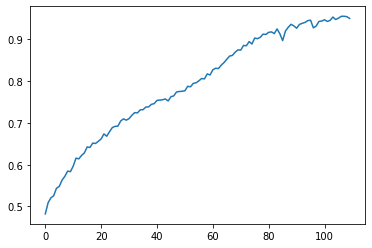

In [ ]:
plt.plot(history.history['acc'])#110epoch AdaBN 

In [ ]:
history.history['acc']

[0.48203131556510925,
 0.5086641907691956,
 0.5205134153366089,
 0.5255230069160461,
 0.5435550212860107,
 0.5477561950683594,
 0.5630809664726257,
 0.5720043182373047,
 0.5845547318458557,
 0.5833084583282471,
 0.5966584086418152,
 0.6157181262969971,
 0.6139501929283142,
 0.6222809553146362,
 0.6283089518547058,
 0.6425380110740662,
 0.6412797570228577,
 0.6517813801765442,
 0.6508265733718872,
 0.6560959219932556,
 0.6617490649223328,
 0.6736911535263062,
 0.6682020425796509,
 0.6791689395904541,
 0.6888440251350403,
 0.6919724345207214,
 0.6922662854194641,
 0.7047748565673828,
 0.7097975015640259,
 0.7067261934280396,
 0.7104003429412842,
 0.718377411365509,
 0.7247669100761414,
 0.7240748405456543,
 0.7314150929450989,
 0.731837272644043,
 0.7380873560905457,
 0.7384318113327026,
 0.7446088790893555,
 0.7463015913963318,
 0.754098653793335,
 0.7547246217727661,
 0.7556378841400146,
 0.7575377821922302,
 0.7526981830596924,
 0.7628585696220398,
 0.7648299932479858,
 0.774289190769

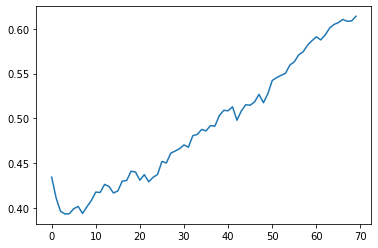

In [ ]:
plt.plot(history.history['acc'])#70epochs_AdaBN 

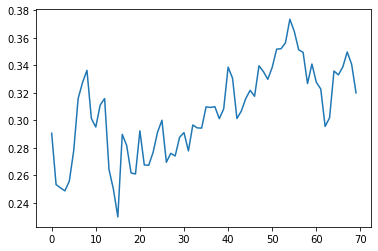

In [ ]:
plt.plot(history.history['val_acc'])#70epochs_AdaBN

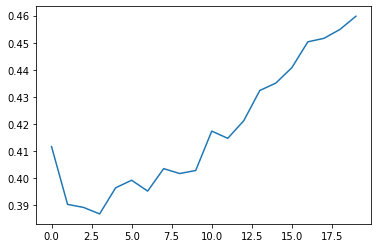

In [ ]:
plt.plot(history.history['acc'])#20epochs

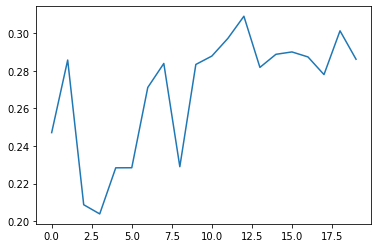

In [ ]:
plt.plot(history.history['val_acc'])#20epoch

#另外一种模型保存方式

In [ ]:
#保存模型参数
model.save_weights("/content/drive/MyDrive/result/model_1227_110epoch_AdaBN_trainTrue.ckpt")

In [ ]:
#调用模型
model = creat_model()

In [ ]:
#加载模型权重
model.load_weights("/content/drive/MyDrive/result/model_1227_110epoch_AdaBN_trainTrue.ckpt")

In [ ]:
model.summary()

In [ ]:
img1_path = glob.glob("/content/drive/MyDrive/SZTAKI_AirChange_Benchmark/Szada_sub_png/im_one/*.png")
img2_path = glob.glob("/content/drive/MyDrive/SZTAKI_AirChange_Benchmark/Szada_sub_png/im_two/*.png")
label_path = glob.glob("/content/drive/MyDrive/SZTAKI_AirChange_Benchmark/Szada_sub_png/ground_truth/*png")

In [ ]:
img1_path

In [ ]:
tf.data.Dataset.from_tensor_slices(())

In [ ]:
def read_img(img_path):
    
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    
    return img

def read_label(label_path):
    
    label = tf.io.read_file(label_path)
    label = tf.image.decode_png(label, channels=1)
    
    return label

def compute_SENet_input(img1_path, img2_path, label_path, img_chazhi):
    img1 = read_img(img1_path)
    img2 = read_img(img2_path)
    label = read_label(label_path)
    chazhi = read_img(img_chazhi)
    
    img1 = tf.cast(img1, tf.float32)/255.0 
    img2 = tf.cast(img2, tf.float32)/255.0 #归一化
    label = tf.cast(label, tf.float32)/255.0 #如果已经在0-1之间则不需要除
    chazhi = tf.cast(chazhi, tf.float32)/255.0
    
    img_pred1 = model.predict(img1)
    img_pred2 = model.predict(img2)
    
    img_FD = tf.subtract(img_pred1, img_pred2)
    img_FD = tf.abs(img_FD)
    
    SENet_input_img = tf.concat([img_FD, img_chazhi], axis=-1)
    
    return SENet_input_img

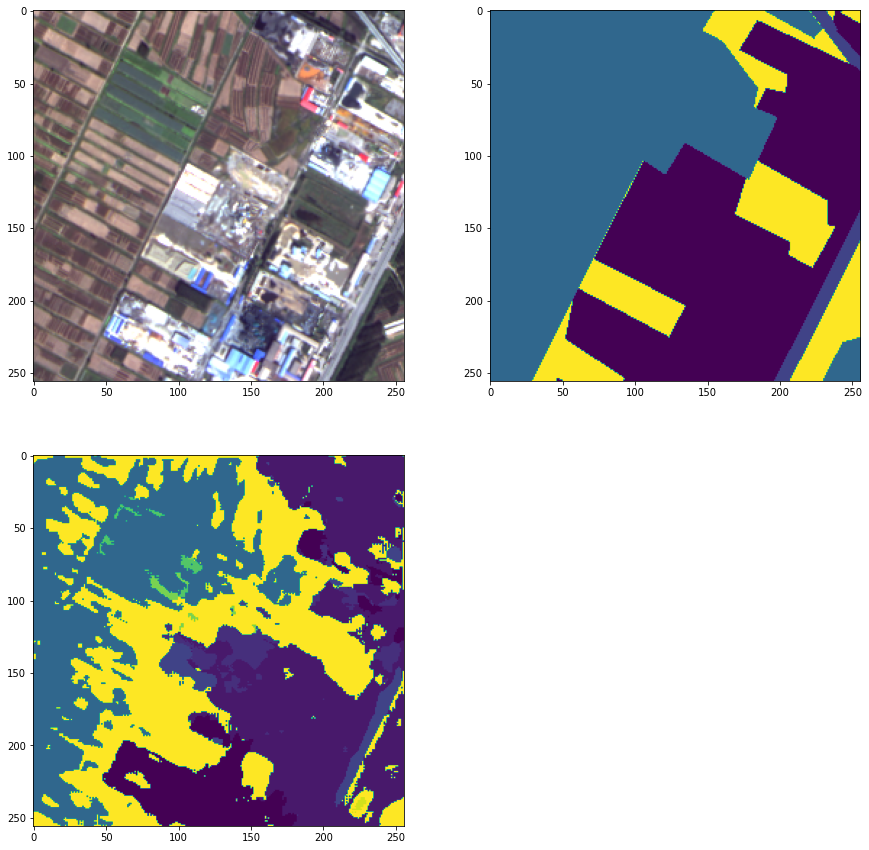

In [ ]:
import matplotlib.pyplot as plt

from PIL import Image

classes = tf.constant([16])

num = 1
for image1, image2 in dataset_val_0.take(3):

  image1_pred = model.predict(image1)
  # image2 = model.predict(image2)

  image1_pred = tf.argmax(image1_pred, axis=-1)
  image1_pred = image1_pred[..., tf.newaxis]

  # image2 = tf.argmax(image2, axis=-1)
  # image2 = image2[..., tf.newaxis]

  # img_CD0 = tf.subtract(image1, image2)
  # img_CD1 = tf.abs(img_CD0)
  # img_CD = tf.divide(img_CD1, tf.cast(classes, dtype=tf.int64))
  # img_CD = tf.argmax(img_CD, axis=-1)
  # img_CD = img_CD[..., tf.newaxis]
  # plt.figure(figsize=(10, 10))
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
image1 = image1.numpy()
image1 = np.squeeze(image1)
plt.imshow(image1)


plt.subplot(2,2,2)
image2 = image2.numpy()
image2 = np.squeeze(image2)
plt.imshow(image2)

plt.subplot(2,2,3)
image1_pred = image1_pred.numpy()
image1_pred = np.squeeze(image1_pred)
plt.imshow(image1_pred)

#模型保存与调用

In [ ]:
model.save("/content/drive/MyDrive/result/ada_model.h5")

In [ ]:
new_model = tf.keras.models.load_model("/content/drive/MyDrive/result/model_val.h5")

In [ ]:
for image1, image2 in dataset_CD.take(2):
  image1 = new_model.predict(image1)
  print(image1)

#直接相减

In [ ]:
import tensorflow as tf
tf.enable_eager_execution()

tf.config.list_physical_devices('GPU')
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import pathlib

In [ ]:
imgt1_path = glob.glob("/content/drive/MyDrive/seasonCD/train/A/*.jpg")
imgt2_path = glob.glob("/content/drive/MyDrive/seasonCD/train/B/*.jpg")

img_A_sub_B = glob.glob("/content/drive/MyDrive/seasonCD/train/A_sub_B/*.jpg")
img_gt = glob.glob("/content/drive/MyDrive/seasonCD/train/OUT/*.jpg")

In [ ]:
imgt2_path[:10]

['/content/drive/MyDrive/seasonCD/train/B/00000.jpg',
 '/content/drive/MyDrive/seasonCD/train/B/00001.jpg',
 '/content/drive/MyDrive/seasonCD/train/B/00002.jpg',
 '/content/drive/MyDrive/seasonCD/train/B/00003.jpg',
 '/content/drive/MyDrive/seasonCD/train/B/00004.jpg',
 '/content/drive/MyDrive/seasonCD/train/B/00005.jpg',
 '/content/drive/MyDrive/seasonCD/train/B/00006.jpg',
 '/content/drive/MyDrive/seasonCD/train/B/00007.jpg',
 '/content/drive/MyDrive/seasonCD/train/B/00008.jpg',
 '/content/drive/MyDrive/seasonCD/train/B/00009.jpg']

In [ ]:
import re
imgt1_path = sorted(imgt1_path,key = lambda i:int(re.search(r'(\d+)',i).group()))
imgt2_path = sorted(imgt2_path,key = lambda i:int(re.search(r'(\d+)',i).group()))
img_A_sub_B = sorted(img_A_sub_B,key = lambda i:int(re.search(r'(\d+)',i).group()))
img_gt = sorted(img_gt,key = lambda i:int(re.search(r'(\d+)',i).group()))

In [ ]:
imgt1_path[-10:]

['/content/drive/MyDrive/seasonCD/train/A/09990.jpg',
 '/content/drive/MyDrive/seasonCD/train/A/09991.jpg',
 '/content/drive/MyDrive/seasonCD/train/A/09992.jpg',
 '/content/drive/MyDrive/seasonCD/train/A/09993.jpg',
 '/content/drive/MyDrive/seasonCD/train/A/09994.jpg',
 '/content/drive/MyDrive/seasonCD/train/A/09995.jpg',
 '/content/drive/MyDrive/seasonCD/train/A/09996.jpg',
 '/content/drive/MyDrive/seasonCD/train/A/09997.jpg',
 '/content/drive/MyDrive/seasonCD/train/A/09998.jpg',
 '/content/drive/MyDrive/seasonCD/train/A/09999.jpg']

In [ ]:
img_A_sub_B[-10:]

['/content/drive/MyDrive/seasonCD/train/A_sub_B/chg_09990.jpg',
 '/content/drive/MyDrive/seasonCD/train/A_sub_B/chg_09991.jpg',
 '/content/drive/MyDrive/seasonCD/train/A_sub_B/chg_09992.jpg',
 '/content/drive/MyDrive/seasonCD/train/A_sub_B/chg_09993.jpg',
 '/content/drive/MyDrive/seasonCD/train/A_sub_B/chg_09994.jpg',
 '/content/drive/MyDrive/seasonCD/train/A_sub_B/chg_09995.jpg',
 '/content/drive/MyDrive/seasonCD/train/A_sub_B/chg_09996.jpg',
 '/content/drive/MyDrive/seasonCD/train/A_sub_B/chg_09997.jpg',
 '/content/drive/MyDrive/seasonCD/train/A_sub_B/chg_09998.jpg',
 '/content/drive/MyDrive/seasonCD/train/A_sub_B/chg_09999.jpg']

In [ ]:
img_root = tf.data.Dataset.from_tensor_slices((imgt1_path))
img_root_t2 = tf.data.Dataset.from_tensor_slices((imgt2_path))
img_root_AsubB = tf.data.Dataset.from_tensor_slices((img_A_sub_B))
img_root_gt = tf.data.Dataset.from_tensor_slices((img_gt))

ValueError: ignored

In [ ]:
def load_img_t1_t2(imgt1_path, imgt2_path):
  imgt1 = read_img_pred(imgt1_path)
  imgt2 = read_img_pred(imgt2_path)
  return imgt1, imgt2
def read_img_train(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.cast(img, tf.float32)/127.5-1
  return img
def read_img_gt(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=1)
  img = tf.cast(img, tf.float32)/127.5-1
  return img

In [ ]:
auto = tf.data.experimental.AUTOTUNE

In [ ]:
img_t1 = img_root_t1.map(read_img_train, num_parallel_calls=auto)
img_t2 = img_root_t2.map(read_img_train, num_parallel_calls=auto)
img_AsubB = img_root_AsubB.map(read_img_train, num_parallel_calls=auto)
img_gt = img_root_gt.map(read_img_gt, num_parallel_calls=auto)

In [ ]:
img_t1_0 = img_t1.cache().repeat().batch(1).prefetch(auto)
img_t2_0 = img_t2.cache().repeat().batch(1).prefetch(auto)
img_AsubB_0 = img_AsubB.cache().repeat().batch(1).prefetch(auto)
img_t1_0 = img_t1.cache().repeat().batch(1).prefetch(auto)

#直接相减生成灰度图

In [ ]:
img_abs_path1 = "/content/drive/MyDrive/seasonCD/train/A/00002.jpg"
img_abs_path2 = "/content/drive/MyDrive/seasonCD/train/B/00002.jpg"
img1 = plt.imread(img_abs_path1)
img2 = plt.imread(img_abs_path2)

In [ ]:
#直接相减 生成灰度列表
img_row = 256
img_columns = 256
img_change = []
temp = np.longfloat(0)
for i in range(img_row):
    for j in range(img_columns):
            temp = np.square(int(img1[i][j][0])-int(img2[i][j][0])) + np.square(int(img1[i][j][1])-int(img2[i][j][1]))\
                   + np.square(int(img1[i][j][2])-int(img2[i][j][2]))
            temp = np.sqrt(temp)
            img_change.append(temp)

In [ ]:
#灰度列表生成灰度图
img_gray = [[0 for col in range(img_columns)] for row in range(img_row)]
img_gray = np.asarray(img_gray, np.float32)

k=0
for i in range(img_row):
    for j in range(img_columns):
        img_gray[i][j] = img_change[k]
        k += 1

In [ ]:
img_gray = np.expand_dims(img_gray, -1)

In [ ]:
img_gray.shape

(256, 256, 1)

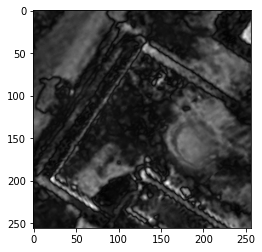

In [ ]:
plt.imshow(np.squeeze(img_gray), cmap='gray')

#模糊C均值聚类

In [ ]:
img = plt.imread('/content/drive/MyDrive/result/12_29result/1.png')
img = img*255.0
img

array([[[ 37., 130., 142., 255.],
        [ 46., 108., 142., 255.],
        [ 48., 104., 141., 255.],
        ...,
        [ 44., 114., 142., 255.],
        [ 44., 112., 142., 255.],
        [ 45., 110., 142., 255.]],

       [[ 33., 141., 140., 255.],
        [ 45., 110., 142., 255.],
        [ 43., 115., 142., 255.],
        ...,
        [ 44., 114., 142., 255.],
        [ 46., 108., 142., 255.],
        [ 45., 111., 142., 255.]],

       [[ 30., 158., 136., 255.],
        [ 32., 145., 140., 255.],
        [ 30., 159., 136., 255.],
        ...,
        [ 46., 107., 142., 255.],
        [ 45., 110., 142., 255.],
        [ 46., 108., 142., 255.]],

       ...,

       [[ 54.,  90., 140., 255.],
        [ 54.,  90., 140., 255.],
        [ 53.,  93., 140., 255.],
        ...,
        [ 55.,  88., 140., 255.],
        [ 56.,  87., 140., 255.],
        [ 46., 108., 142., 255.]],

       [[ 56.,  86., 139., 255.],
        [ 55.,  88., 140., 255.],
        [ 54.,  90., 140., 255.],
        .

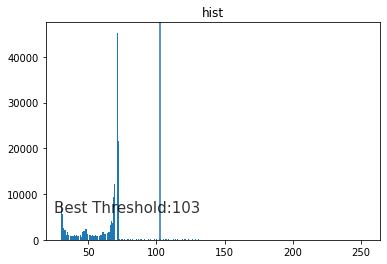

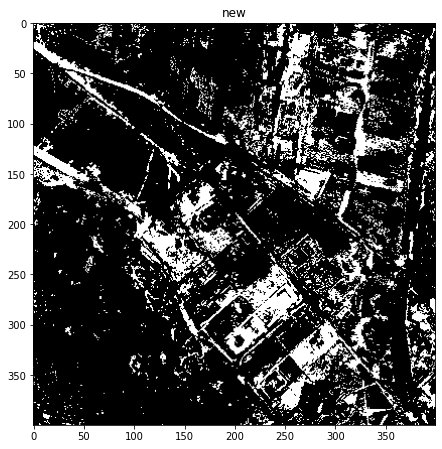

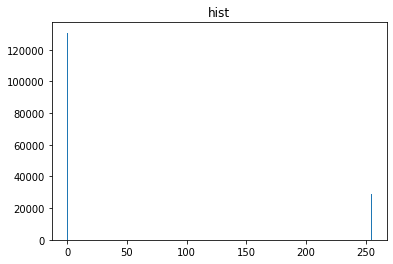

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
#读入图片并转化为矩阵
img = plt.imread('/content/drive/MyDrive/result/1_5result/Unet_SEnet600Epochs.png')
img = img*255.0
img = img[:, :, :1]
im = np.array(img)

# 矩阵大小
l = len(im)
w = len(im[0])

#求初始阈值
zmin = np.min(im)
zmax = np.max(im)
t0 = int((zmin+zmax)/2)

#初始化相关变量初始化
t1=0
res1=0
res2=0
s1=0
s2=0

#迭代法计算最佳阈值
while abs(t0-t1)>0:
  for i in range(0,l-1):
    for j in range(0,w-1):
      if im[i,j]<t0:
        res1=res1+im[i,j]
        s1=s1+1
      elif im[i,j]>t0:
        res2=res2+im[i,j]
        s2=s2+1
  avg1=res1/s1
  avg2=res2/s2
  res1 = 0
  res2 = 0
  s1 = 0
  s2 = 0
  t1 = t0     #旧阈值储存在t1中
  t0=int((avg1+avg2)/2)   #计算新阈值

#阈值化分割
#像素点灰度值小于最佳阈值t0用0填充，其余用255填充
# im = np.where(im[...,:] < t0, 0, 255)
im = np.where(im[...,:] < 45, 0, 255)

#绘制原图窗口
# plt.figure()
# plt.imshow(img , cmap='gray')
# plt.title('original')

#绘制原图直方图并显示最佳阈值
plt.figure()
plt.hist(img.ravel(),256)
plt.title('hist')
plt.axvline(t0)    #绘制最佳阈值分割线
plt.text(25, 6100, "Best Threshold:{}".format(t0), size = 15, alpha = 0.8)

#绘制阈值化分割后图像
plt.figure(figsize=(7.4, 7.4))
# print(im.shape)
# plt.imshow(Image.fromarray(im) , cmap='gray')
im = 255-im
plt.imshow(np.squeeze(im), cmap='gray')
plt.title('new')

#绘制阈值化分割后图像的直方图
plt.figure()
plt.hist(im.ravel(),400)
plt.title('hist')

plt.show()


In [ ]:
!pip uninstall scipy==1.4.1

Uninstalling scipy-1.4.1:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/scipy-1.4.1.dist-info/*
    /usr/local/lib/python3.6/dist-packages/scipy/*
Proceed (y/n)? y
  Successfully uninstalled scipy-1.4.1


In [ ]:
!pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 99kB/s 
ERROR: umap-learn 0.4.6 has requirement scipy>=1.3.1, but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [ ]:
import scipy
scipy.__version__

'1.1.0'

In [ ]:
import scipy.misc as misc
# scipy.misc(im).save("/content/drive/MyDrive/result/1_5result/threshold600epoch.png")
import PIL.Image as Image
im = np.squeeze(im)
im = Image.fromarray(np.uint8(im))
misc.toimage(im).save("/content/drive/MyDrive/result/1_5result/threshold600epoch.png")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning:     `toimage` is deprecated!
    `toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use Pillow's ``Image.fromarray`` directly instead.
  


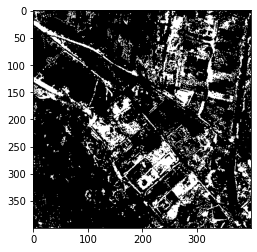

In [ ]:
plt.imshow(np.squeeze(im), cmap='gray')

In [ ]:
im = np.squeeze(im)
im.shape

(400, 400)

In [ ]:
plt.imsave("/content/drive/MyDrive/result/1_5result/threshold600epoch.png", im)

In [ ]:
import cv2
import numpy as np
 
C = 2
M = 2
EPSILON = 0.000005
 
def get_init_fuzzy_mat(pixel_count):
    global C
    fuzzy_mat = np.zeros((C, pixel_count))
    for col in range(pixel_count):
        temp_sum = 0
        randoms = np.random.rand(C - 1, 1)
        for row in range(C - 1):
            fuzzy_mat[row, col] = randoms[row, 0] * (1 - temp_sum)
            temp_sum += fuzzy_mat[row, col]
        fuzzy_mat[-1, col] = 1 - temp_sum
    return fuzzy_mat
 
def get_centroids(data_array, fuzzy_mat):
    global M
    class_num, pixel_count = fuzzy_mat.shape[:2]
    centroids = np.zeros((class_num, 1))
    for i in range(class_num):
        fenzi = 0.
        fenmu = 0.
        for pixel in range(pixel_count):
            fenzi += np.power(fuzzy_mat[i, pixel], M) * data_array[0, pixel]
            fenmu += np.power(fuzzy_mat[i, pixel], M)
        centroids[i,0] = fenzi / fenmu
    return centroids
 
def eculidDistance(vectA, vectB):
    return np.sqrt(np.sum(np.power(vectA - vectB, 2)))
 
def eculid_distance(pixel_1, pixel_2):
    return np.power(pixel_1-pixel_2, 2)
 
def cal_fcm_function(fuzzy_mat, centroids, data_array):
    global M
    class_num, pixel_count = fuzzy_mat.shape[:2]
    target_value = 0.0
    for c in range(class_num):
        for p in range(pixel_count):
            target_value += eculid_distance(data_array[0,p], centroids[c,0])*np.power(fuzzy_mat[c,p], M)
    return target_value
 
def get_label(fuzzy_mat, data_array):
    pixel_count = data_array.shape[1]
    label = np.zeros((1,pixel_count))
 
    for i in range(pixel_count):
        if fuzzy_mat[0,i] > fuzzy_mat[1,i]:
            label[0,i] = 255
        else:
            label[0,i] = 0
    return label
 
def cal_fuzzy_mat(data_array, centroids):
    global M
    pixel_count = data_array.shape[1]
    class_num = centroids.shape[0]
    new_fuzzy_mat = np.zeros((class_num, pixel_count))
    for p in range(pixel_count):
        for c in range(class_num):
            temp_sum = 0.
            Dik = eculid_distance(data_array[0,p], centroids[c,0])
            for i in range(class_num):
                temp_sum += np.power(Dik/(eculid_distance(data_array[0,p], centroids[i,0])), (1/(M-1)))
            new_fuzzy_mat[c,p] = 1/temp_sum
    return new_fuzzy_mat
 
def fcm(init_fuzzy_mat, init_centroids, data_array):
    global EPSILON
    last_target_function = cal_fcm_function(init_fuzzy_mat, init_centroids, data_array)
    print("迭代次数 = 1, 目标函数值 = {}".format(last_target_function))
    fuzzy_mat = cal_fuzzy_mat(data_array, init_centroids)
    centroids = get_centroids(data_array, fuzzy_mat)
    target_function = cal_fcm_function(fuzzy_mat, centroids, data_array)
    print("迭代次数 = 2, 目标函数值 = {}".format(target_function))
    count = 3
    while count < 100:
        if abs(target_function-last_target_function) <= EPSILON:
            break
        else:
            last_target_function = target_function
            fuzzy_mat = cal_fuzzy_mat(data_array, centroids)
            centroids = get_centroids(data_array, fuzzy_mat)
            target_function = cal_fcm_function(fuzzy_mat, centroids, data_array)
            print("迭代次数 = {}, 目标函数值 = {}".format(count, target_function))
            count += 1
    return fuzzy_mat, centroids, target_function
 
 
 
# image = cv2.imread(r"C:\Users\Desktop\test.jpg", cv2.IMREAD_GRAYSCALE)
image=img_gray
# rows, cols = image.shape[:2]
rows, cols = 400, 400
pixel_count = rows * cols
image_array = image.reshape(1, pixel_count)
# print(image_array[1])
# 初始模糊矩阵
init_fuzzy_mat = get_init_fuzzy_mat(pixel_count)
# 初始聚类中心
init_centroids = get_centroids(image_array, init_fuzzy_mat)
fuzzy_mat, centroids, target_function = fcm(init_fuzzy_mat, init_centroids, image_array)
label = get_label(fuzzy_mat, image_array)
new_image = label.reshape(rows, cols)
# cv2.imshow("result", new_image)
# cv2.imwrite("fcm_result.jpg",new_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

迭代次数 = 1, 目标函数值 = 293.07335400058963
迭代次数 = 2, 目标函数值 = 220.04571073044556
迭代次数 = 3, 目标函数值 = 219.96191175919762
迭代次数 = 4, 目标函数值 = 218.7115740991284
迭代次数 = 5, 目标函数值 = 204.31001537839933
迭代次数 = 6, 目标函数值 = 146.5252587006169
迭代次数 = 7, 目标函数值 = 109.48232003819986
迭代次数 = 8, 目标函数值 = 105.53295218577014
迭代次数 = 9, 目标函数值 = 105.34463481440568
迭代次数 = 10, 目标函数值 = 105.3331300618764
迭代次数 = 11, 目标函数值 = 105.33167743176502
迭代次数 = 12, 目标函数值 = 105.33141998673901
迭代次数 = 13, 目标函数值 = 105.33137109853547
迭代次数 = 14, 目标函数值 = 105.3313617089525
迭代次数 = 15, 目标函数值 = 105.33135990204117


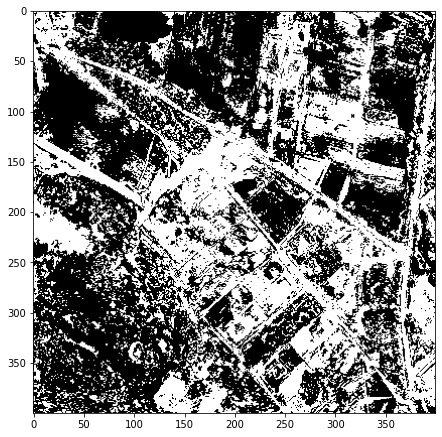

In [ ]:
# new_image1 = np.expand_dims(new_image, -1)
plt.figure(figsize=(7.4, 7.4))
plt.imshow(np.squeeze(new_image1), cmap='gray')

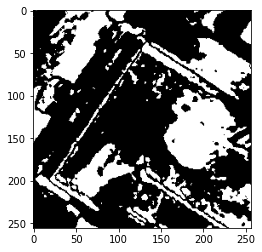

In [ ]:
# new_image1 = np.expand_dims(new_image, -1)
plt.imshow(np.squeeze(new_image1), cmap='gray')

In [ ]:
new_image1 = 255 - new_image1
new_image1 = new_image1/255

In [ ]:
new_image1.shape

(256, 256, 1)

In [ ]:
new_img = np.squeeze(new_image1)
#减少内容为空的维度 np.squeeze

In [ ]:
from PIL import Image

In [ ]:
plt.imsave("/content/drive/MyDrive/result/gray_img/binary_2.png", new_img)

# model.predict

In [ ]:
import glob
import re
img1_path = glob.glob("/content/drive/MyDrive/Szada_four_sub_png/Szada_four_sub_png_second/im_one/*.png")
img2_path = glob.glob("/content/drive/MyDrive/Szada_four_sub_png/Szada_four_sub_png_second/im_two/*.png")
img1_path = sorted(img1_path,key = lambda i:int(re.search(r'(\d+)',i).group()))
img2_path = sorted(img2_path,key = lambda i:int(re.search(r'(\d+)',i).group()))

In [ ]:
img2_path

In [ ]:
img_model = tf.data.Dataset.from_tensor_slices((img1_path, img2_path))

In [ ]:
def read_model_img(img1_path, img2_path):
    img1 = tf.io.read_file(img1_path)
    img1 = tf.image.decode_png(img1, channels=3) 
    img1 = tf.expand_dims(img1, 0)
    img1 = tf.cast(img1, tf.float32)/255.0 

    img2 = tf.io.read_file(img2_path)
    img2 = tf.image.decode_png(img2, channels=3)
    img2 = tf.expand_dims(img2, 0)
    img2 = tf.cast(img2, tf.float32)/255.0 

    return img1, img2

In [ ]:
# BATCH_SIZE = 1
# BUFFER_SIZE = 30
# step_per_epoch = 72//BATCH_SIZE
auto = tf.data.experimental.AUTOTUNE

In [ ]:
imgx, imgy = read_model_img("/content/drive/MyDrive/Szada_four_sub_png/im_one/"+str(1)+".png", "/content/drive/MyDrive/Szada_four_sub_png/im_two/2.png")

In [ ]:
for i in range(1, 43):
  imgx, imgy = read_model_img("/content/drive/MyDrive/Szada_four_sub_png/im_one/"+str(i)+".png", 
                              "/content/drive/MyDrive/Szada_four_sub_png/im_two/"+str(i)+".png")
  pred1 = model.predict(imgx)
  pred2 = model.predict(imgy)

  pred1 = np.squeeze(pred1)
  pred2 = np.squeeze(pred2)

  pred = np.abs(pred1-pred2)

  np.save("/content/drive/MyDrive/Szada_four_sub_png/model_predict_np/"+str(i)+".npy", pred)

In [ ]:
a = np.load("/content/drive/MyDrive/Szada_four_sub_png/model_predict_np/24.npy")
b = np.load("/content/drive/MyDrive/Szada_four_sub_png/model_predict_np/10.npy")

In [ ]:
a[:2, :2]

array([[[3.2079607e-01, 3.4437299e-02, 1.3402504e-03, 1.2907904e-01,
         1.1562561e-02, 2.5870539e-02, 2.7551703e-02, 2.2223039e-02,
         6.6355750e-04, 2.3608314e-04, 6.8030169e-04, 1.0648748e-03,
         4.9482484e-04, 8.7771725e-05, 1.1561104e-02, 4.8280990e-01],
        [5.6572032e-01, 1.6259413e-02, 8.1105973e-04, 1.2914321e-01,
         6.9255070e-03, 6.7342087e-03, 4.3939594e-02, 2.1913595e-02,
         3.0570477e-04, 7.7428143e-05, 2.8595366e-04, 4.9559190e-04,
         6.9031012e-07, 2.2344011e-08, 1.0625264e-02, 6.6757977e-01]],

       [[4.6320495e-01, 1.8651672e-02, 1.9875815e-04, 8.5675806e-02,
         9.9712703e-03, 1.0177018e-02, 3.4007914e-02, 2.0634942e-02,
         1.6275277e-04, 3.6329886e-05, 3.3147700e-04, 4.3639424e-04,
         5.2292817e-06, 2.6802909e-06, 9.8474231e-03, 5.4172212e-01],
        [6.4201415e-01, 4.0262491e-03, 1.2300145e-04, 1.4275819e-02,
         2.4116242e-03, 3.1868096e-03, 2.6031092e-02, 9.9618081e-03,
         7.1726332e-05, 6.512

In [ ]:
b[:2, :2]

array([[[3.91818956e-03, 2.32330058e-03, 4.61957529e-02, 1.06015325e-01,
         6.23371307e-05, 5.34663141e-01, 5.91633953e-02, 5.69138676e-02,
         2.22840086e-02, 3.64082716e-02, 9.00180778e-04, 3.10295308e-03,
         4.02419269e-01, 4.67297481e-03, 1.68217032e-03, 2.43139341e-01],
        [1.69665203e-03, 8.52194789e-04, 3.07010598e-02, 5.36689758e-02,
         1.26973455e-05, 6.88882709e-01, 9.88635272e-02, 7.07407892e-02,
         1.78127866e-02, 2.67532170e-02, 7.49489554e-05, 7.66271260e-04,
         7.66939223e-01, 1.30127755e-03, 4.39737662e-04, 1.13275073e-01]],

       [[2.30967416e-03, 6.15570345e-04, 3.60648222e-02, 1.31980225e-01,
         1.21566882e-05, 7.10223198e-01, 8.46543014e-02, 5.88988028e-02,
         1.33461459e-02, 2.10514963e-02, 1.77621070e-04, 2.44461419e-03,
         5.86672127e-01, 2.41351919e-03, 7.70653656e-04, 2.02717572e-01],
        [1.13177777e-03, 2.81334040e-04, 3.23026031e-02, 1.90785006e-02,
         1.42128499e-06, 7.50710547e-01, 1.030

In [ ]:
img_model_input = img_model.map(read_model_img, num_parallel_calls=auto)

In [ ]:
img_model_input = img_model_input.cache().prefetch(auto)

In [ ]:
import numpy as np
from PIL import Image
for i in range(1,73):
  for img1, img2 in img_model_input.take(i):
    pred1 = model.predict(img1)
    pred2 = model.predict(img2)

    pred1 = np.squeeze(pred1)
    pred2 = np.squeeze(pred2)

    pred = np.abs(pred1-pred2)

    # p = i - 1
    np.save("/content/drive/MyDrive/Szada_four_sub_png/Szada_four_sub_png_second/model_predict_np/"+str(i)+".npy", pred)

In [ ]:
c = np.load("/content/drive/MyDrive/Szada_four_sub_png/Szada_four_sub_png_second/model_predict_np/72.npy")

In [ ]:
pred[:2,:2]

In [ ]:
c[:2,:2]

In [ ]:
b[:2,:2]

In [ ]:
pred.shape

(400, 400, 16)

# SENet数据输入管道

In [ ]:
import glob
import re
import tensorflow as tf

In [ ]:
img_np = glob.glob("/content/drive/MyDrive/Szada_four_sub_png/Szada_four_sub_png_second/model_predict_np/*.npy")
img_chazhi = glob.glob("/content/drive/MyDrive/Szada_four_sub_png/Szada_four_sub_png_second/chazhi/*.png")
img_np = sorted(img_np,key = lambda i:int(re.search(r'(\d+)',i).group()))
img_chazhi = sorted(img_chazhi,key = lambda i:int(re.search(r'(\d+)',i).group()))

In [ ]:
len(img_np)

72

In [ ]:
#生成senet的input
for i in range(72):
  FD_chazhi = read_np(img_np[i])
  chazhi = read_chazhi(img_chazhi[i])

  # print(FD_chazhi.shape)
  se_input = np.concatenate((FD_chazhi, chazhi), axis=-1)

  print(se_input.shape)
  p = i+1
  np.save("/content/drive/MyDrive/Szada_four_sub_png/Szada_four_sub_png_second/senet_input/"+str(p)+".npy", se_input)
print('over')

In [ ]:
a = np.load("/content/drive/MyDrive/Szada_four_sub_png/Szada_four_sub_png_second/senet_input/1.npy")
b = np.load("/content/drive/MyDrive/Szada_four_sub_png/Szada_four_sub_png_second/senet_input/2.npy")

In [ ]:
def read_np(img_np):
  a = np.load(img_np)
  # b = tf.convert_to_tensor(a)
  return a

def read_chazhi(img_chazhi):
  img =plt.imread(img_chazhi)
  img = img[:,:,:3]

  return img

In [ ]:
dataset_path = tf.data.Dataset.from_tensor_slices((img_np, img_chazhi))

In [ ]:
aaa = read_chazhi("/content/drive/MyDrive/SZTAKI_AirChange_Benchmark/Szada_sub_png/two_png_sub/0.png")

In [ ]:
bbb = read_np("/content/drive/MyDrive/SZTAKI_AirChange_Benchmark/Szada_sub_png/model_predict_np/0.npy")

In [ ]:
def read_np(img_np):
  a = np.load(img_np)
  b = tf.convert_to_tensor(a)
  
  return b 

def read_chazhi(img_chazhi):
  img = tf.io.read_file(img_chazhi)
  img = tf.image.decode_png(img, channels=3)
  img = tf.cast(img, tf.float32)/255.0

  return img

def sc_se_input(img_np, img_chazhi):
  chazhi = read_chazhi(img_chazhi)
  FD_chazhi = read_np(img_np)
  se_input = tf.concat([chazhi, FD_chazhi], axis=-1)
  
  return se_input

In [ ]:
sc_se_input("/content/drive/MyDrive/SZTAKI_AirChange_Benchmark/Szada_sub_png/two_png_sub/0.png", "/content/drive/MyDrive/SZTAKI_AirChange_Benchmark/Szada_sub_png/model_predict_np/0.npy")

# senet

In [ ]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
tf.config.list_physical_devices('GPU')
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import pathlib
import glob
import re

In [ ]:
senet_input_path = glob.glob("/content/drive/MyDrive/Szada_four_sub_png/Szada_four_sub_png_second/senet_input/*.npy")
senet_label = glob.glob("/content/drive/MyDrive/Szada_four_sub_png/Szada_four_sub_png_second/gt/*.png")
senet_input_path = sorted(senet_input_path,key = lambda i:int(re.search(r'(\d+)',i).group()))
senet_label = sorted(senet_label,key = lambda i:int(re.search(r'(\d+)',i).group()))

In [ ]:
len(senet_input_path)

72

In [ ]:
test_path = senet_input_path[:2]
# test_label_path = senet_label[:2]

senet_input_path = senet_input_path[2:]
senet_label = senet_label[2:]

In [ ]:
dataset_path = tf.data.Dataset.from_tensor_slices((senet_input_path, senet_label))

In [ ]:
test_path = tf.data.Dataset.from_tensor_slices((test_path))

In [ ]:
def decode_npy(npy):
  filename = npy.numpy()
  data = np.load(filename)
  return data

def read_dataset(senet_input_np, senet_label):
  
  a = tf.py_function(decode_npy, [senet_input_np], tf.float32)
  a.set_shape([400,400,19])

  img = tf.io.read_file(senet_label)
  img = tf.io.decode_png(img, channels=1)
  img = tf.cast(img, tf.float32)/255.0

  img.set_shape([400,400,1])

  if tf.random.uniform(()) > 0.5:
    a = tf.image.flip_left_right(a)
    img = tf.image.flip_left_right(img)
  
  # img = tf.reshape(img, [256, 256, 1])

  return a, img

In [ ]:
def read_dataset_val(senet_input_np):
  
  a = tf.py_function(decode_npy, [senet_input_np], tf.float32)
  a.set_shape([400,400,19])

  # img = tf.io.read_file(senet_label)
  # img = tf.io.decode_png(img, channels=1)
  # img = tf.cast(img, tf.float32)/255.0

  # img.set_shape([400,400,1])

  #img = tf.reshape(img, [256, 256, 1])

  return a

In [ ]:
# dataset = dataset_path.map(read_dataset, num_parallel_calls=auto)
# dataset = dataset_path.map(lambda x, y: tf.py_function(read_dataset, inp=[x, y], Tout=[tf.float32, tf.float32]))
auto = tf.data.experimental.AUTOTUNE
dataset = dataset_path.map(read_dataset, num_parallel_calls=auto)

In [ ]:
test_ds = test_path.map(read_dataset_val, num_parallel_calls=auto)

In [ ]:
test_ds.take(1)

<TakeDataset shapes: (400, 400, 19), types: tf.float32>

In [ ]:
for i,k in dataset.take(1):
  # print(i)
  print(np.unique(k))

[0. 1.]


In [ ]:
BATCH_SIZE = 1
BUFFER_SIZE = 50
step_per_epoch = 70//BATCH_SIZE
auto = tf.data.experimental.AUTOTUNE

In [ ]:
dataset_0 = dataset.cache().shuffle(30).batch(1).prefetch(auto)
# dataset_train_0 = dataset_train.cache().repeat().shuffle(100).batch(1).prefetch(auto)

In [ ]:
test_ds_0 = test_ds.batch(1).cache().prefetch(auto)

In [ ]:
dataset_0.take(1)

<TakeDataset shapes: ((None, 400, 400, 19), (None, 400, 400, 1)), types: (tf.float32, tf.float32)>

In [ ]:
for a,b in dataset_0.take(1):
  print(type(a))
  print(b.numpy())

<class 'tensorflow.python.framework.ops.EagerTensor'>
[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]]


#SENet模块

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten,Reshape, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
def SENet_model():
  input = tf.keras.layers.Input(shape=(400, 400, 19))
  # print("111")
  x1 = tf.keras.layers.Conv2D(16, 1, padding='same', activation='relu')(input)

  x2 = tf.keras.layers.Conv2D(8, 1, padding='same', activation='relu')(x1)

  x3 = tf.keras.layers.Conv2D(4, 1, padding='same', activation='relu')(x2)

  sequeeze = GlobalAveragePooling2D()(x3)

  excitation = Dense(2)(sequeeze)
  excitation = Activation('relu')(excitation)
  excitation = Dense(4)(excitation)
  excitation = Activation('sigmoid')(excitation)
  excitation = Reshape((1,1,4))(excitation)
  scale = tf.multiply(x3, excitation)

  output = tf.keras.layers.Conv2D(2, 1, padding='same', activation='sigmoid')(scale)

  return tf.keras.Model(inputs=input, outputs=output)

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten,Reshape, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
def SENet_model():
  input = tf.keras.layers.Input(shape=(400, 400, 19))
  # print("111")
  x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(input)
  x = AdaptiveBatchNormalization()(x, training=True)
  #400 400 32

  x1 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
  x1 = AdaptiveBatchNormalization()(x1, training=True)
  x1 = tf.keras.layers.MaxPool2D()(x1)
  #200 200 64

  x2 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x1)
  x2 = AdaptiveBatchNormalization()(x2, training=True)
  x2 = tf.keras.layers.MaxPool2D()(x2)
  #100 100 128

  x3 = tf.keras.layers.Conv2DTranspose(64, 2, strides=2, 
                          padding='same', activation='relu')(x2)
  x4 = tf.concat([x3, x1], axis=-1)# 200 200 128
  x4 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x4)
  x4 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x4)

  x5 = tf.keras.layers.Conv2DTranspose(32, 2, strides=2, 
                          padding='same', activation='relu')(x4)
  x6 = tf.concat([x5, x], axis=-1)
  x6 = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(x6)
  x6 = tf.keras.layers.Conv2D(16, 3, padding='same', activation='softmax')(x6)
  sequeeze = GlobalAveragePooling2D()(x6)

  excitation = Dense(8)(sequeeze)
  excitation = Activation('relu')(excitation)
  excitation = Dense(16)(excitation)
  excitation = Activation('sigmoid')(excitation)
  excitation = Reshape((1,1,16))(excitation)
  scale = tf.multiply(x6, excitation)
  # print(excitation)

  output = tf.keras.layers.Conv2D(2, 1, padding='same', activation='softmax')(scale)

  return tf.keras.Model(inputs=input, outputs=output)

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten,Reshape, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
def SENet_model():
  input = tf.keras.layers.Input(shape=(400, 400, 19))
  # print("111")
  x1 = tf.keras.layers.Conv2D(19, 1, padding='same', activation='relu')(input)

  sequeeze = GlobalAveragePooling2D()(x1)

  excitation = Dense(9)(sequeeze)
  excitation = Activation('relu')(excitation)
  excitation = Dense(19)(excitation)
  excitation = Activation('sigmoid')(excitation)
  excitation = Reshape((1,1,19))(excitation)
  scale = tf.multiply(x1, excitation)
  # print(excitation)

  output = tf.keras.layers.Conv2D(2, 1, padding='same', activation='sigmoid')(scale)

  return tf.keras.Model(inputs=input, outputs=output)

In [ ]:
model_se = SENet_model()

In [ ]:
def focal_loss(alpha=0.5, gamma=1.5, epsilon=1e-6):
    print('*'*20, 'alpha={}, gamma={}'.format(alpha, gamma))
    def focal_loss_calc(y_true, y_probs):
        positive_pt = tf.where(tf.equal(y_true, 1), y_probs, tf.ones_like(y_probs))
        negative_pt = tf.where(tf.equal(y_true, 0), 1-y_probs, tf.ones_like(y_probs))
        
        loss =  -alpha * tf.pow(1-positive_pt, gamma) * tf.math.log(tf.clip_by_value(positive_pt, epsilon, 1.)) - \
            (1-alpha) * tf.pow(1-negative_pt, gamma) * tf.math.log(tf.clip_by_value(negative_pt,  epsilon, 1.))

        return tf.reduce_sum(loss)
    return focal_loss_calc
alphas = np.arange(0.1, 0.41, 0.05)#[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
gammas = np.arange(1., 4.1, 0.5)#[1.0, 1.5, 2., 2.5, 3., 3.5, 4.]


In [ ]:
# model_se.compile(
#     optimizer = 'adam',
#     # loss = 'categorical_crossentropy',
#     loss = tf.keras.losses.BinaryCrossentropy(),
#     metrics = ['acc']
# )
model_se.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy',
    # loss='binary_crossentropy',
    # loss=focal_loss(alpha=0.5, gamma=1.5),
    metrics=['accuracy', ]
)

In [ ]:
EPOCHS = 100

In [ ]:
history = model_se.fit(dataset_0,
            epochs=EPOCHS,
            steps_per_epoch=step_per_epoch
)

Epoch 1/100
70/70 [==============================] - 3s 31ms/step - loss: 58.9258 - accuracy: 0.0444
Epoch 2/100
70/70 [==============================] - 2s 30ms/step - loss: 57.0522 - accuracy: 0.0454
Epoch 3/100
70/70 [==============================] - 2s 30ms/step - loss: 55.8436 - accuracy: 0.0386
Epoch 4/100
70/70 [==============================] - 2s 30ms/step - loss: 53.9596 - accuracy: 0.0458
Epoch 5/100
70/70 [==============================] - 2s 30ms/step - loss: 52.9519 - accuracy: 0.0388
Epoch 6/100
70/70 [==============================] - 2s 30ms/step - loss: 50.9461 - accuracy: 0.0505
Epoch 7/100
70/70 [==============================] - 2s 30ms/step - loss: 50.0785 - accuracy: 0.0411
Epoch 8/100
70/70 [==============================] - 2s 30ms/step - loss: 48.6699 - accuracy: 0.0410
Epoch 9/100
70/70 [==============================] - 2s 30ms/step - loss: 46.8575 - accuracy: 0.0473
Epoch 10/100
70/70 [==============================] - 2s 31ms/step - loss: 45.4485 - accura

In [ ]:
test_ds_0.take(1)

<TakeDataset shapes: (None, 400, 400, 19), types: tf.float32>

In [ ]:
for i in test_ds_0.take(1):
  pred = model_se.predict(i)

  pred = np.squeeze(pred)

In [ ]:
pred = np.max(pred, axis=-1)
pred = np.squeeze(pred)
# pred.shape
np.unique(pred)

array([0.73419887, 0.73874766, 0.73955226, ..., 0.9486211 , 0.94876456,
       0.94890565], dtype=float32)

In [ ]:
pred = pred*255
pred = 255 - pred

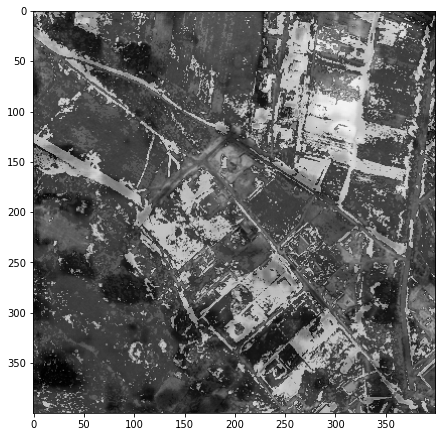

In [ ]:
# pred = pred*255
plt.figure(figsize=(7.4,7.4))
plt.imshow(pred, cmap='gray')# 72pictures UNetSEnt 400 epochs

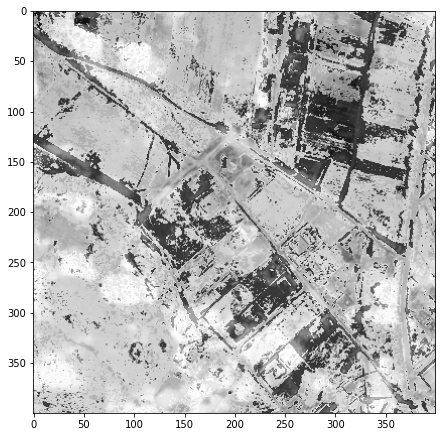

In [ ]:
# pred = pred*255
plt.figure(figsize=(7.4,7.4))
plt.imshow(pred, cmap='gray')# 72pictures UNetSEnt 200 epochs

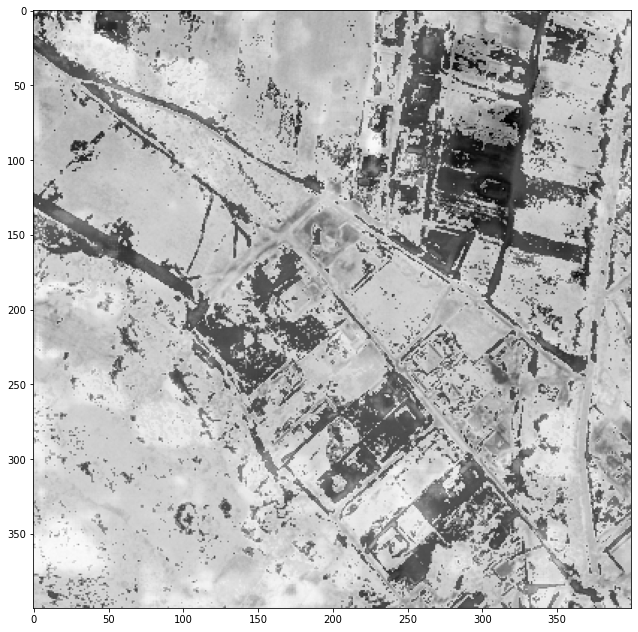

In [ ]:
# pred = pred*255
plt.figure(figsize=(11,11))
plt.imshow(pred, cmap='gray')# 72pictures UNetSEnt 400 epochs

In [ ]:
pred.shape

(400, 400)

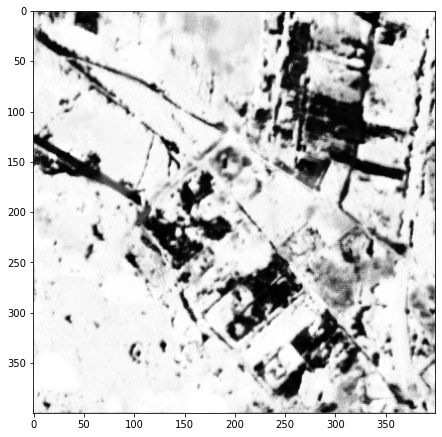

In [ ]:
# pred = pred*255
plt.figure(figsize=(7.4,7.4))
plt.imshow(pred, cmap='gray')# UNetSEnt 100 epochs

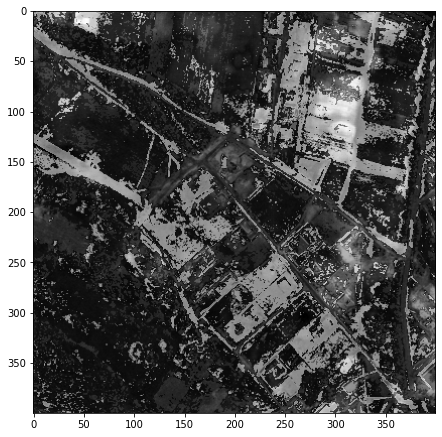

In [ ]:
plt.figure(figsize=(7.4,7.4))
plt.imshow(pred, cmap='gray')# UNetSEnt 600 epochs

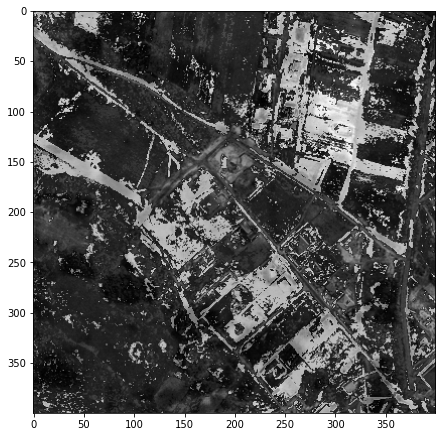

In [ ]:
plt.figure(figsize=(7.4,7.4))
plt.imshow(pred, cmap='gray')# UNetSEnt 400 epochs

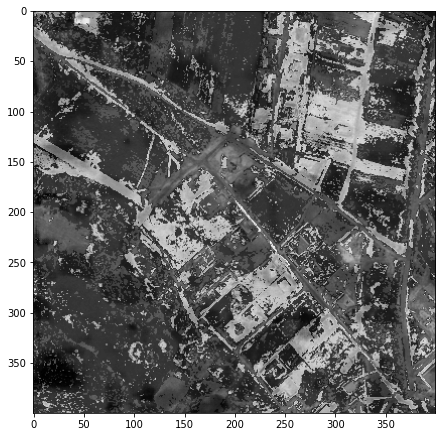

In [ ]:
plt.figure(figsize=(7.4,7.4))
plt.imshow(pred, cmap='gray')# UNetSEnt 200 epochs

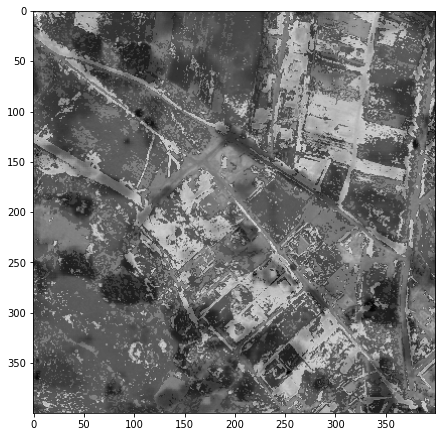

In [ ]:
plt.figure(figsize=(7.4,7.4))
plt.imshow(pred, cmap='gray')# UNetSEnt 110 epochs 

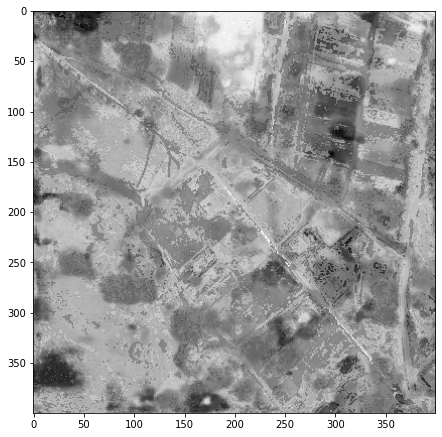

In [ ]:
plt.figure(figsize=(7.4,7.4))
plt.imshow(pred, cmap='gray')# UNetSEnt 40 epochs 

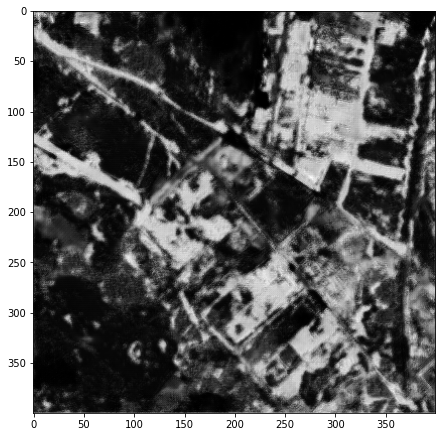

In [ ]:
plt.figure(figsize=(7.4,7.4))
plt.imshow(pred, cmap='gray')# UNetSEnt 70 epochs 

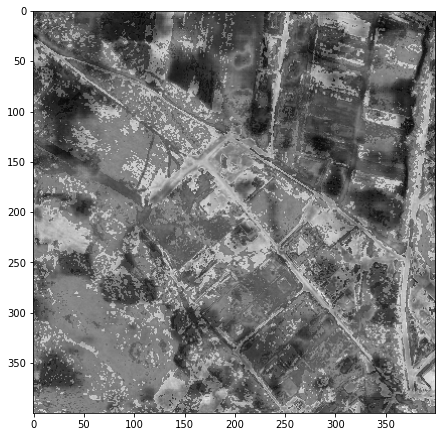

In [ ]:
plt.figure(figsize=(7.4,7.4))
plt.imshow(pred, cmap='gray')# 40 epochs 

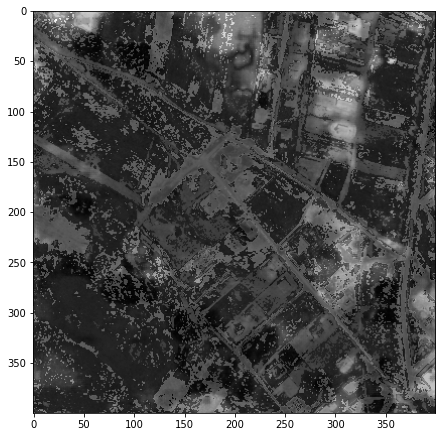

In [ ]:
plt.figure(figsize=(7.4,7.4))
plt.imshow(pred, cmap='gray')# 55 epochs

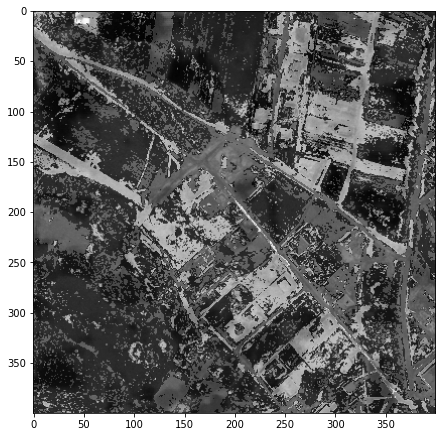

In [ ]:
plt.figure(figsize=(7.4,7.4)) 
plt.imshow(pred, cmap='gray')#100 epochs 

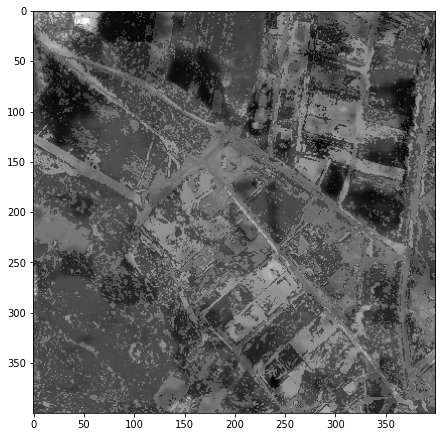

In [ ]:
plt.figure(figsize=(7.4,7.4))
plt.imshow(pred, cmap='gray')

In [ ]:
import matplotlib 
matplotlib.image.imsave("/content/drive/MyDrive/result/1_5result/72pictures_Unet_SEnet600Epochs.png", pred)

NameError: ignored

In [ ]:
for i,j in dataset_0.take(1):
  pred = model_se.predict(i)
  # print(type(pred))
  pred = np.squeeze(pred)

In [ ]:
pred = np.max(pred, axis=-1)
pred = np.squeeze(pred)
pred.shape

(400, 400)

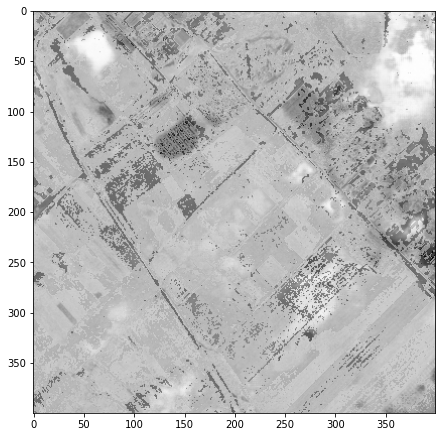

In [ ]:
plt.figure(figsize=(7.4,7.4))
plt.imshow(pred, cmap='gray')

In [ ]:
np.save("/content/drive/MyDrive/result/huidutu12_23.npy", pred)

<Figure size 720x720 with 0 Axes>

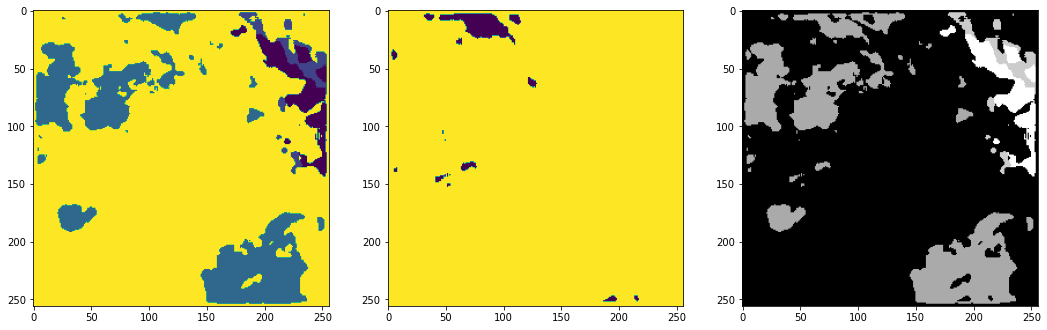

In [ ]:
import matplotlib.pyplot as plt

from PIL import Image

classes = tf.constant([16])

num = 1
for image1, image2 in dataset_CD.take(1):

  image1 = new_model.predict(image1)
  image2 = new_model.predict(image2)

  image1 = tf.argmax(image1, axis=-1)
  image1 = image1[..., tf.newaxis]

  image2 = tf.argmax(image2, axis=-1)
  image2 = image2[..., tf.newaxis]

  img_CD0 = tf.subtract(image1, image2)
  img_CD1 = tf.abs(img_CD0)
  img_CD = tf.divide(img_CD1, tf.cast(classes, dtype=tf.int64))
  # img_CD = tf.argmax(img_CD, axis=-1)
  # img_CD = img_CD[..., tf.newaxis]
  plt.figure(figsize=(10, 10))
  for i in range(num):
    # plt.imshow(image1)
    plt.figure(figsize=(18,6))
    plt.subplot(num, 3, i*num+1)
    img1 = np.squeeze(image1[i].numpy())
    plt.imshow(img1)
    # plt.imsave("/content/drive/MyDrive/result/CD_subtract/T1_img.png", img1)

    plt.subplot(num, 3, i*num+2)
    img2 = np.squeeze(image2[i].numpy())
    img_num = img2
    plt.imshow(img2)
    # img2 = np.expand_dims(img2, -1).repeat(3, axis=-1)
    # plt.imsave("/content/drive/MyDrive/result/CD_subtract/T2_img.png", img2)
    # plt.imshow(tf.keras.preprocessing.image.array_to_img(image2[i]))

    plt.subplot(num, 3, i*num+3)
    # print(img_CD[i].numpy().shape)
    # plt.imsave("/content/drive/MyDrive/result/CD_subtract/CD_img.png", img_CD[i].numpy())
    
    img3 = np.squeeze(img_CD[i].numpy())
    # print(img3.shape)
    # plt.imshow(img3, cmap='gray')
    # img3 = np.expand_dims(img3, -1)
    # img3_gray = Image.fromarray(np.uint8(img_CD[i].numpy()))
    # plt.imsave("/content/drive/MyDrive/result/CD_subtract/CD_img.png", img3_gray)
    # plt.imshow(tf.keras.preprocessing.image.array_to_img(img_CD[i]))
    plt.imshow(np.squeeze(img_CD.numpy()), cmap='gray')
    a = np.squeeze(img_CD[i].numpy())
    # print(image.shape)
    # print(pred_mask[i])

In [ ]:
img_huidutu = img_CD.numpy()

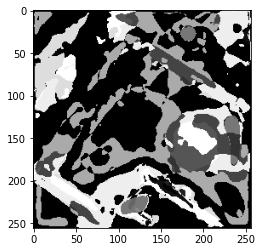

In [ ]:
plt.imshow(np.squeeze(img_huidutu), cmap='gray')

In [ ]:
img3 = "/content/drive/MyDrive/result/CD_subtract/CD_12.png"
img3 = plt.imread(img3)

In [ ]:
img3_1 = Image.fromarray(np.uint8(img3))

In [ ]:
img3_1

In [ ]:
plt.imsave("/content/drive/MyDrive/result/CD_subtract/CD_3.png",img3_1)

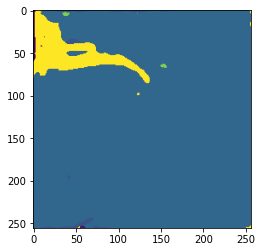

In [ ]:
img_path0 = "/content/drive/MyDrive/result/CD_subtract/CD_3.png"
img = plt.imread(img_path0)
plt.imshow(img[:,:,:3], cmap='gray')

In [ ]:
num = 3
for image, mask in dataset_val_0.take(1):
  pred_mask = model.predict(image)
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]

  plt.figure(figsize=(10, 10))
  for i in range(num):
    plt.subplot(num, 3, i*num+1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image[i]))
    plt.subplot(num, 3, i*num+2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[i]))
    plt.subplot(num, 3, i*num+3)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask[i]))
    # print(image.shape)
    print(pred_mask[i])

In [ ]:
#tensorflow 没有直接读取解码tiff文件的API，
#需要利用其它方法将tiff文件转换为jpg或者png格式的文件，
#注意：要求逐个通道转换，因为标记数据是逐个通道的，而非混在一起的

#层的重用
将层定义为一个变量（初始化为一个变量）

layer = Dense(70, activation='relu')#初始化

x = layer(x)#第一次调用

x = layer(x)#第二次调用

只有这样才能保证调用的层是共享权重的


#模型重用
keras的模型跟一个层差不多，也可以实现重用，在另一个model中直接调用就可以。


#

In [ ]:
img_tests = "/content/drive/MyDrive/WHU_seg_ftclass_png/sub_label_huidutu//0.jpg"

In [ ]:
img = plt.imread(img_tests)

In [ ]:
img

array([[6, 6, 5, ..., 6, 6, 6],
       [6, 5, 5, ..., 6, 6, 6],
       [4, 5, 5, ..., 6, 6, 6],
       ...,
       [6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6]], dtype=uint8)

In [ ]:
def create_model():
    ## unet网络结构下采样部分
    # 输入层 第一部分
    inputs = tf.keras.layers.Input(shape = (256,256,3))
    
    x = tf.keras.layers.Conv2D(64,3,padding="same",activation="relu")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64,3,padding="same",activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)  #  256*256*64
    # 下采样
    x1 = tf.keras.layers.MaxPooling2D(padding="same")(x) # 128*128*64
    
    # 卷积 第二部分
    x1 = tf.keras.layers.Conv2D(128,3,padding="same",activation="relu")(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Conv2D(128,3,padding="same",activation="relu")(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)  #  128*128*128
    # 下采样 
    x2 = tf.keras.layers.MaxPooling2D(padding="same")(x1) # 64*64*128
        
    # 卷积 第三部分
    x2 = tf.keras.layers.Conv2D(256,3,padding="same",activation="relu")(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    x2 = tf.keras.layers.Conv2D(256,3,padding="same",activation="relu")(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)  #  64*64*256
    # 下采样
    x3 = tf.keras.layers.MaxPooling2D(padding="same")(x2) # 32*32*256
    
    # 卷积 第四部分
    x3 = tf.keras.layers.Conv2D(512,3,padding="same",activation="relu")(x3)
    x3 = tf.keras.layers.BatchNormalization()(x3)
    x3 = tf.keras.layers.Conv2D(512,3,padding="same",activation="relu")(x3)
    x3 = tf.keras.layers.BatchNormalization()(x3)  #  32*32*512
    # 下采样
    x4 = tf.keras.layers.MaxPooling2D(padding="same")(x3) # 16*16*512
    # 卷积  第五部分
    x4 = tf.keras.layers.Conv2D(1024,3,padding="same",activation="relu")(x4)
    x4 = tf.keras.layers.BatchNormalization()(x4)
    x4 = tf.keras.layers.Conv2D(1024,3,padding="same",activation="relu")(x4)
    x4 = tf.keras.layers.BatchNormalization()(x4)  #  16*16*1024
    
    ## unet网络结构上采样部分
    
    # 反卷积 第一部分      512个卷积核 卷积核大小2*2 跨度2 填充方式same 激活relu
    x5 = tf.keras.layers.Conv2DTranspose(512,2,strides=2,
                                         padding="same",
                                         activation="relu")(x4)#32*32*512
    x5 = tf.keras.layers.BatchNormalization()(x5)
    x6 = tf.concat([x3,x5],axis=-1)#合并 32*32*1024
    # 卷积
    x6 = tf.keras.layers.Conv2D(512,3,padding="same",activation="relu")(x6)
    x6 = tf.keras.layers.BatchNormalization()(x6)
    x6 = tf.keras.layers.Conv2D(512,3,padding="same",activation="relu")(x6)
    x6 = tf.keras.layers.BatchNormalization()(x6)  #  32*32*512
    
    # 反卷积 第二部分
    x7 = tf.keras.layers.Conv2DTranspose(256,2,strides=2,
                                         padding="same",
                                         activation="relu")(x6)#64*64*256
    x7 = tf.keras.layers.BatchNormalization()(x7)
    x8 = tf.concat([x2,x7],axis=-1)#合并 64*64*512
    # 卷积
    x8 = tf.keras.layers.Conv2D(256,3,padding="same",activation="relu")(x8)
    x8 = tf.keras.layers.BatchNormalization()(x8)
    x8 = tf.keras.layers.Conv2D(256,3,padding="same",activation="relu")(x8)
    x8 = tf.keras.layers.BatchNormalization()(x8)  #  #64*64*256
    
    # 反卷积 第三部分
    x9 = tf.keras.layers.Conv2DTranspose(128,2,strides=2,
                                         padding="same",
                                         activation="relu")(x8)# 128*128*128
    x9 = tf.keras.layers.BatchNormalization()(x9)
    x10 = tf.concat([x1,x9],axis=-1)#合并 128*128*256
    # 卷积
    x10 = tf.keras.layers.Conv2D(128,3,padding="same",activation="relu")(x10)
    x10 = tf.keras.layers.BatchNormalization()(x10)
    x10 = tf.keras.layers.Conv2D(128,3,padding="same",activation="relu")(x10)
    x10 = tf.keras.layers.BatchNormalization()(x10)  # 128*128*128
    
    # 反卷积 第四部分
    x11 = tf.keras.layers.Conv2DTranspose(64,2,strides=2,
                                         padding="same",
                                         activation="relu")(x10)#  256*256*64
    x11 = tf.keras.layers.BatchNormalization()(x11)
    x12 = tf.concat([x,x11],axis=-1)#合并 256*256*128
    # 卷积
    x12 = tf.keras.layers.Conv2D(64,3,padding="same",activation="relu")(x12)
    x12 = tf.keras.layers.BatchNormalization()(x12)
    x12 = tf.keras.layers.Conv2D(64,3,padding="same",activation="relu")(x12)
    x12 = tf.keras.layers.BatchNormalization()(x12)  # 256*256*64
    
    # 输出层 第五部分
    x12 =tf.keras.layers.Conv2D(16,1,padding="same",activation="softmax")(x12)# 256*256*34
    
    output = tf.argmax(x12, axis=-1)
    return tf.keras.Model(inputs=inputs,outputs=output)
    


In [ ]:
model = creat_model()

In [ ]:
# tf.keras.metrics.MeanIoU(num_classes=34) # 根据独热编码进行计算
# 我们是顺序编码 需要更改类
# class MeanIou(tf.keras.metrics.MeanIoU): # 继承这个类 
#     def __call__(self,y_true,y_pred,sample_weight=None): 
#         y_pred = tf.argmax(u_pred,axis=-1) 
#         return super().__call__(y_true,y_pred,sample_weight=sample_weight)
# # 编译模型
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["acc",tf.keras.metrics.MeanIoU(num_classes=16)]
             )


In [ ]:
# 训练
history = model.fit(dataset_train_0,
                    epochs=1,
                    steps_per_epoch=step_per_epoch,
                    validation_steps=val_per,
                    validation_data=dataset_val_0
                   )


#**评价指标**

In [ ]:
# MIoU
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [ ]:
npy1 = np.load("/content/drive/MyDrive/Szada_four_sub_png/Szada_four_sub_png_second/senet_input/1.npy")

In [ ]:
npy1.shape

(400, 400, 19)

In [ ]:
type(npy1)

numpy.ndarray

In [ ]:
a = npy1[:,:,18]

In [ ]:
a.shape

(400, 400)

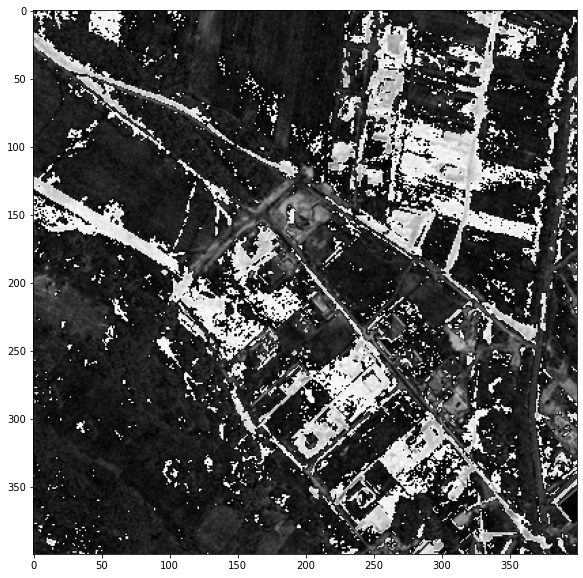

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(a,cmap='gray')
# plt.legend(ncol)

In [ ]:
import PIL.Image as Image
b = Image.fromarray(np.uint8(a))
plt.imsave("/content/drive/MyDrive/result/21_1_24result/model3_3.png", b)

NameError: ignored

In [ ]:
import numpy as np
from PIL import Image
for i in range(1,2):
  for img1, img2 in img_model_input.take(i):
    pred1 = model.predict(img1)
    pred2 = model.predict(img2)

    pred1 = np.squeeze(pred1)
    pred2 = np.squeeze(pred2)

    pred = np.abs(pred1-pred2)
    np.save("/content/drive/MyDrive/result/21_1_24result/"+str(i)+"_pred1.npy", pred1)
    np.save("/content/drive/MyDrive/result/21_1_24result/"+str(i)+"_pred2.npy", pred2)

    # p = i - 1
    np.save("/content/drive/MyDrive/result/21_1_24result/"+str(i)+".npy", pred)

In [ ]:
img_chazhitu = plt.imread("/content/drive/MyDrive/Szada_four_sub_png/chazhi/1.png")

In [ ]:
img_chazhitu.shape

(400, 400, 4)

In [ ]:
a = img_chazhitu[:,:,0]

In [ ]:
a.shape

(400, 400)

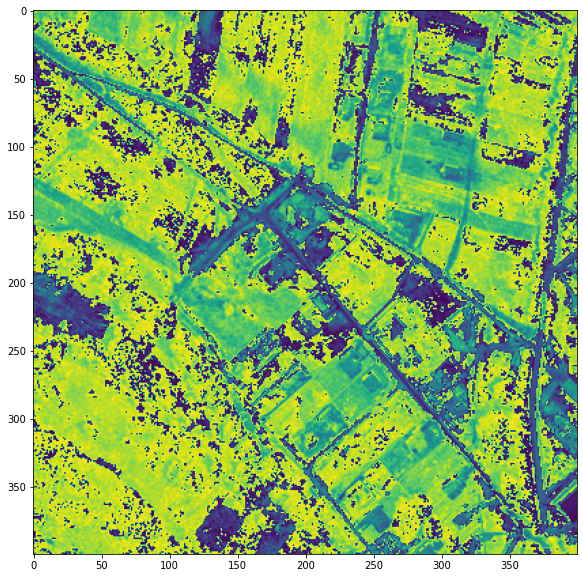

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(a)

In [ ]:
import PIL.Image as Image
b = Image.fromarray(np.uint8(a))
plt.imsave("/content/drive/MyDrive/result/21_1_24result/chazhi_3.png", b)